<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project2_transport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: Tracer transport

A critical aspect of understanding climate and environmental systems is describing the movement of substances. This could include pollution or water vapor in the atmosphere, salt in an estuary, or chemicals in a river. We often model the transport of these substances using an advection/diffusion equation for the concentration of the substance. In this context, we sometimes refer to the concentration field as a `tracer' since it helps us track the movement of individual molecules. We can also use this framework to describe the transport of heat, although in this case the tracer field (temperature or heat content) tracks the movement of thermal energy.

In this project we will use Dedalus to solve advection diffusion equations to describe the vertical distribution of heat in the ocean and the concentration of pollution in a river.

Student tasks are in [Section 1.4](#section1pt4), [Section 1.6](#section1pt6), and [Section 2.3](#section2pt3)

## Setup
If you are using Google colab, run the script below to install Dedalus

In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus not installed yet.
Installing for Google Colab.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
Suggested packages:
  libfftw3-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-double3 libfftw3-long3 libfftw3-quad3
  libfftw3-single3
0 upgraded, 6 newly installed, 0 to remove and 41 not upgraded.
Need to get 4,654 kB of archives.
After this operation, 24.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-double3 amd64 3.3.8-2ubuntu8 [770 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu8 [335 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-quad3 amd64 3.3.8-2ubuntu8 [614 kB]
Get:4 http://arch

## 1. Thermal structure in the ocean

Most of the ocean has a stable thermal stratification with warm water at the surface and cold water in the abyss (exceptions occur in salt-stratified waters like the Arctic Ocean). Since the ocean is a massive thermal reservoir, understanding the distribution of this heat is important to quantifying the ocean's role in a changing climate. The structure of the temperature field can also inform us about the circulation in the ocean interior.


### 1.1 Measured temperature profile

The code below plots a sample temperature profile obtained off the coast of California. The data was obtained by digitizing Figure 3 in Munk, 1966.

Text(0, 0.5, 'Depth (m)')

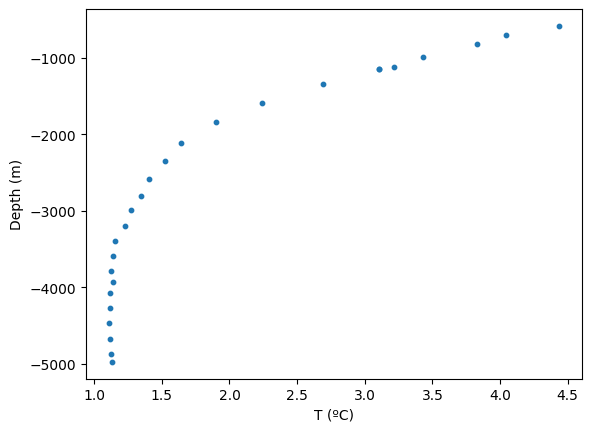

In [2]:
import matplotlib.pyplot as plt

# Temperature measurements extracted from Figure 3 in Munk, 1966
CTD_T = [1.1296296296296295, 1.122004357298475, 1.1143790849673203, 1.1067538126361656, 1.1143790849673203, 1.1143790849673203, 1.1372549019607843, 1.122004357298475, 1.1372549019607843, 1.1525054466230937, 1.2287581699346406, 1.2745098039215685, 1.343137254901961, 1.4041394335511983, 1.526143790849673, 1.6405228758169934, 1.8997821350762527, 2.242919389978214, 2.69281045751634, 3.104575163398693, 3.104575163398693, 3.218954248366013, 3.4324618736383443, 3.8289760348583877, 4.042483660130719, 4.438997821350762]
CTD_z = [-4976.958525345623, -4869.431643625192, -4677.419354838709, -4470.046082949309, -4270.353302611367, -4070.6605222734256, -3932.411674347158, -3786.4823348694317, -3586.78955453149, -3394.7772657450078, -3195.084485407066, -2995.3917050691243, -2803.379416282642, -2580.6451612903224, -2350.230414746544, -2112.1351766513058, -1843.3179723502303, -1597.5422427035332, -1344.0860215053763, -1144.3932411674346, -1144.3932411674346, -1121.351766513057, -990.7834101382491, -821.8125960061443, -698.9247311827958, -583.7173579109067]

plt.scatter(CTD_T,CTD_z,s=10)
plt.xlabel('T (ºC)')
plt.ylabel('Depth (m)')


### 1.2 Abyssal recipes

Munk (1966) proposed that the thermal structure of the ocean interior is set by a balance between upwelling and diffusion. In this view, cold waters sink near the poles and spread across the seafloor before slowly rising through the ocean interior. If we assume, as Munk did, that the water upwells uniformly across the globe, the upwelling speed is approximately $10^{-7}$ m/s. This is far too small to directly measure, but it is large enough to have a major impact on the distribution of tracers. Since light can only penetrate through the top ~100m of ocean, we can ignore solar heating, except in that it sets the temperature near the ocean surface.

### 1.3 Steady advection/diffusion equation

Dedalus can solve differential equations in various forms. In addition to time-dependent initial value problems (IVPs), Dedalus can solve linear and nonlinear boundary value problems. The code below uses Dedalus to solve a linear boundary value problem (IVBP) for the steady state advection/diffusion equation.

Here, the top and bottom temperature are set from the measured profile and these are used as boundary conditions. The vertical (upwelling) velocity is set to $10^{-7} m/s$, and the diffusivity is set to $10^{-7}$ $m^2/s$, to approximate the molecular diffusivity of heat in seawater.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.7e+00/s


2025-11-11 19:49:32,436 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.7e+00/s


Text(0, 0.5, 'Depth (m)')

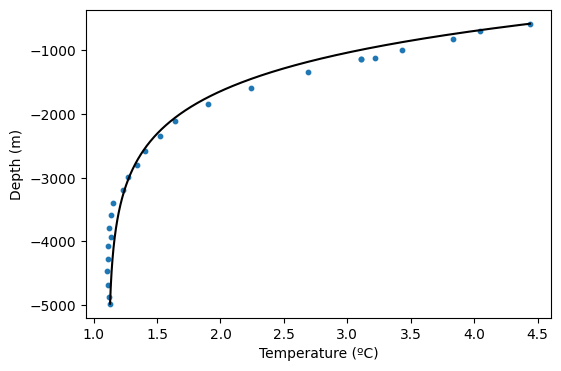

In [3]:
"""
Dedalus script to solve the steady advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the upwelling velocity
w = 1e-7 # m/s
# Set the diffusivity
kappa= 8e-5 # m^2/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - kappa*Tzz = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

### 1.4 Student investigation
<a id='section1pt4'></a>
Note that the profile above is not a good fit to the data. This implies that molecular diffusion isn't sufficient to transport heat down from the surface and stop the ocean from filling up with cold, dense water.

Munk (1966) proposed that small-scale turbulence in the ocean interior results in a diffusivity that is orders of magnitude larger than the molecular value. Find a diffusivity that gives a good match with the data and test it in the Dedalus script above. Comment on the ability of this model (steady advection/diffusion) to fit the data.

After several iterations it was found that kappa=8e-5 produced the best fit. This is almost 3 orders of magnitude higher than that predicted by the molecular level alone. This suggests that the mollecular level diffusion is insignificant in the process of heat transport in the ocean in comparison to the role of turbulence.
With K=8e-5, the model predicts the behaviour fairly well but it still oversmooths. It fails to represent the near-isothermal behaviour of the very deep ocean and the shoudler of the curve is at a slightly lower depth, resulting in an overestimate of surface temperatures by up to half a degree.

### 1.5 Turning ocean mixing upside down

Decades of research to measure the turbulent diffusivity in the ocean consistently found values much smaller than the one predicted by Munk (1966). Specifically, while larger values of the turbulent diffusivity were found near the bottom of the ocean over rough topographic features, the values in the upper ocean were about 10x smaller than the values predicted by Munk. 50 years after Munk's seminal paper, Ferrari et al. (2016) proposed that a depth-dependent turbulent diffusivity could be balanced by <em>downwelling</em>, with negative vertical velocities in the ocean interior. In this theory, the overturning circulation is upwelling in thin boundary layers along the sloping sides of the ocean basins.

When the diffusivity, $\kappa$, is a function of $z$, the steady advection/diffusion equation can be written

$$ w\frac{dT}{dz} = \frac{d}{dz}\left(\kappa(z) \frac{dT}{dz}\right)$$

The Dedalus script below solves the previous equation and again compares the results with the observed temperature profile. For the depth-dependent diffusivity, $\kappa(z)$, we take

$$ \kappa(z)=\kappa_{bg} + (\kappa_0-\kappa_{bg})e^{-(z+D)/l} $$

using the form from Rogers et al., 2023, where $\kappa_{bg}=1\times 10^{-5} m^2/s$ is the background diffusivity characteristic of the upper water column, $\kappa_0=8.6\times 10^{-4} m^2/s$ characterizes the enhanced mixing near the bottom of the ocean, $D$ is a reference depth where $\kappa=\kappa_0$, and $l=667m$ is an exponential decay scale. In the script below, we start with $w=0$.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


2025-11-11 19:49:33,374 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s


Text(0, 0.5, 'Depth (m)')

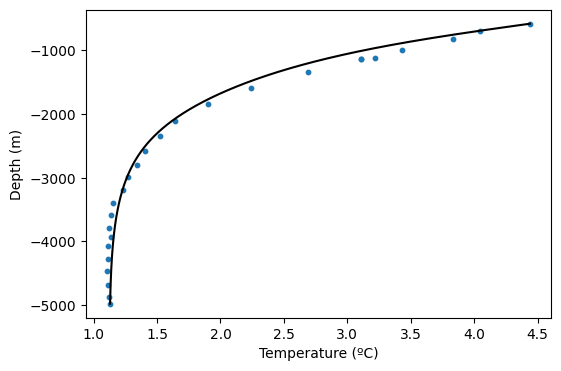

In [4]:
"""
Dedalus script to solve the steady advection/diffusion equation
with a spatially-variable diffusivity
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the vertical velocity
w = 1e-8 # m/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)
kappa = dist.Field(name='kappa', bases=zbasis)
# Set the diffusivity
# Below is the diffusivity profile from Rogers et al., 2023
kappa['g']=(1e-5 + (8.6e-4-1e-5)*np.exp((-5e3-z)/667)) # m^2/s

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

### 1.6 Student investigation
<a id='section1pt6'></a>
Note from the results of the script above that the density profile is reasonable, even though $w=0$. In the box below, comment on the balance in this case and what this implies about the diffusive heat flux.

Next, find a vertical velocity that produces a better agreement with the observations and report it below. Then, try varying the details of the $\kappa(z)$ profile. How sensitive is the optimal $w$ to your choice of $\kappa(z)$? What does this imply about the circulation in the ocean interior if $\kappa(z)$ varies between regions of smooth and rough topography?

(As an aside, note that the requied vertical velocity is much smaller than the one used by Munk (1966). This implies that the dense, cold water that sinks at the poles must rise elsewhere. Ferrari et al. (2016) proposed that this occurs in boundary layers near the seafloor.)

If w=0, $$\frac{d}{dz}\left(\kappa(z) \frac{dT}{dz}\right) =0 $$
implying that $\kappa (z) \frac{dT}{dz} $ is a constant which means that any changes to kappa must be balanced by changes to the heat flux, $-k \frac{dT}{dz}$. This shows that the diffusivity is linked to the heat flux ie in this example, initally, $\frac{dt}{dz} is very large which implies small kappa, then as dt/dz decreases kappa will increase.

best fit: w = 1e-8

varying kappa:
when we mulitplied $\kappa$ by 5, the solution became less accurate. We had to multiply w by 5 to get a best fit model. Similarly, when $\kappa$ was reduced by a factor of 5 the best fit w was 0.2 of that used in the initial condition, ie 2e-9. This is shown in the plots below. This implies that w varies linearly with the value of k so w and k are very closely related. Physically, this means that the downwelling velcoity will vary in parts of the ocean with different diffusivities ie different topographies.



INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.2e+00/s


2025-11-11 19:49:34,605 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.2e+00/s


Text(0, 0.5, 'Depth (m)')

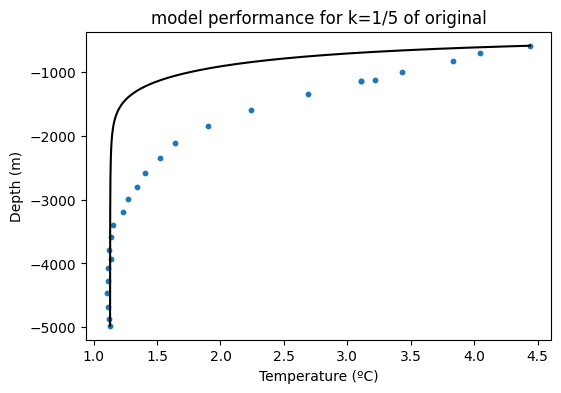

In [5]:
#w=1e-8, kappa=0.2kappa(z)
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the vertical velocity
w = 1e-8 # m/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)
kappa = dist.Field(name='kappa', bases=zbasis)
# Set the diffusivity
# Below is the diffusivity profile from Rogers et al., 2023
kappa['g']=0.2*(1e-5 + (8.6e-4-1e-5)*np.exp((-5e3-z)/667)) # m^2/s

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.title ('model performance for k=1/5 of original')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.0e+00/s


2025-11-11 19:49:36,293 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.0e+00/s


Text(0, 0.5, 'Depth (m)')

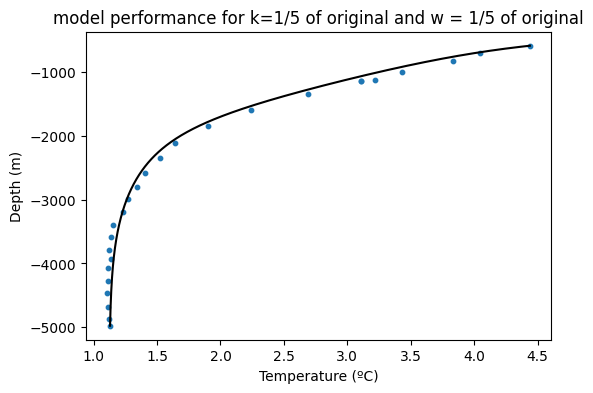

In [6]:
#w=2e-9 kappa = 0.2kappa(z)
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the vertical velocity
w = 2e-9 # m/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)
kappa = dist.Field(name='kappa', bases=zbasis)
# Set the diffusivity
# Below is the diffusivity profile from Rogers et al., 2023
kappa['g']=0.2*(1e-5 + (8.6e-4-1e-5)*np.exp((-5e3-z)/667)) # m^2/s

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.title('model performance for k=1/5 of original and w = 1/5 of original')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

## 2. Transport of pollution in a river

Advection/diffusion equations are a common way to model the material transport in many physical systems. In this section we will model the transport and dilution of a pollutants added to a river.

For simplicity, we will model the river as a rectangular channel, and we will neglect depth variations. Let $x$ be the coordinate along the length of the river, and $y$ be the cross-stream coordinate. We will model the river current as

$$ u(y) = U_0\left(1-\frac{(y-w/2)^2}{(w/2)^2}\right) $$

where $w$ is the width of the river and $U_0$ is the maximum current speed which occurs at the center of the river (the $y$-coordinate will run from 0 to $w$).

Since we want to know how the pollution levels vary in time, we will solve the time-dependent advection/diffusion equation. We will model the addition of pollution by adding a spatially-dependent source term to the right hand side of the equation governing pollutant concentration:

$$ \frac{\partial c}{\partial t} + u(y)\frac{\partial c}{\partial x} = \kappa \nabla^2 c + S(x,y) $$

where $\nabla^2=(\partial_x^2 + \partial_y^2)$ is the Laplacian operator for diffusion in 2D Cartesian coordinates, and $S$ is the source term.

### 2.1 Dedalus script

The script below solves the time-dependent advection/diffusion equation with a source term.

In [24]:
"""
Script to solve the time-dependent advection/diffusion equation
"""


import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Set parameters
U0 = 0.1 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='c', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.0e+00/s


2025-11-11 19:53:55,839 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.0e+00/s


INFO:__main__:Starting main loop


2025-11-11 19:53:55,846 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2025-11-11 19:53:55,883 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2025-11-11 19:53:55,906 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2025-11-11 19:53:55,932 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2025-11-11 19:53:55,955 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2025-11-11 19:53:55,979 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2025-11-11 19:53:56,003 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2025-11-11 19:53:56,027 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2025-11-11 19:53:56,051 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2025-11-11 19:53:56,074 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2025-11-11 19:53:56,098 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2025-11-11 19:53:56,127 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2025-11-11 19:53:56,152 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2025-11-11 19:53:56,176 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2025-11-11 19:53:56,203 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2025-11-11 19:53:56,227 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2025-11-11 19:53:56,256 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2025-11-11 19:53:56,289 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2025-11-11 19:53:56,315 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2025-11-11 19:53:56,340 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2025-11-11 19:53:56,364 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2025-11-11 19:53:56,391 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2025-11-11 19:53:56,418 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2025-11-11 19:53:56,455 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2025-11-11 19:53:56,479 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2025-11-11 19:53:56,507 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2025-11-11 19:53:56,531 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2025-11-11 19:53:56,558 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2025-11-11 19:53:56,582 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2025-11-11 19:53:56,609 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2025-11-11 19:53:56,634 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2025-11-11 19:53:56,663 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2025-11-11 19:53:56,687 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2025-11-11 19:53:56,711 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2025-11-11 19:53:56,738 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2025-11-11 19:53:56,763 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2025-11-11 19:53:56,787 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2025-11-11 19:53:56,812 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2025-11-11 19:53:56,836 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2025-11-11 19:53:56,861 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2025-11-11 19:53:56,885 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2025-11-11 19:53:56,913 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2025-11-11 19:53:56,936 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2025-11-11 19:53:56,961 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2025-11-11 19:53:56,985 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2025-11-11 19:53:57,009 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2025-11-11 19:53:57,033 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2025-11-11 19:53:57,058 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2025-11-11 19:53:57,083 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2025-11-11 19:53:57,107 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2025-11-11 19:53:57,131 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2025-11-11 19:53:57,156 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2025-11-11 19:53:57,182 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2025-11-11 19:53:57,209 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2025-11-11 19:53:57,233 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2025-11-11 19:53:57,257 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2025-11-11 19:53:57,281 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2025-11-11 19:53:57,317 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2025-11-11 19:53:57,343 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2025-11-11 19:53:57,368 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2025-11-11 19:53:57,392 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2025-11-11 19:53:57,419 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2025-11-11 19:53:57,446 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2025-11-11 19:53:57,470 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2025-11-11 19:53:57,498 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2025-11-11 19:53:57,524 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2025-11-11 19:53:57,549 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2025-11-11 19:53:57,573 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2025-11-11 19:53:57,598 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2025-11-11 19:53:57,624 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2025-11-11 19:53:57,649 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2025-11-11 19:53:57,674 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2025-11-11 19:53:57,701 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2025-11-11 19:53:57,727 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2025-11-11 19:53:57,753 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2025-11-11 19:53:57,779 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2025-11-11 19:53:57,806 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2025-11-11 19:53:57,832 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2025-11-11 19:53:57,852 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2025-11-11 19:53:57,853 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2025-11-11 19:53:57,858 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.2432 sec


2025-11-11 19:53:57,861 solvers 0/1 INFO :: Setup time (init - iter 0): 0.2432 sec


INFO:solvers:Warmup time (iter 0-10): 0.05718 sec


2025-11-11 19:53:57,864 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.05718 sec


INFO:solvers:Run time (iter 10-end): 1.948 sec


2025-11-11 19:53:57,866 solvers 0/1 INFO :: Run time (iter 10-end): 1.948 sec


INFO:solvers:CPU time (iter 10-end): 0.0005412 cpu-hr


2025-11-11 19:53:57,869 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0005412 cpu-hr


INFO:solvers:Speed: 6.746e+06 mode-stages/cpu-sec


2025-11-11 19:53:57,872 solvers 0/1 INFO :: Speed: 6.746e+06 mode-stages/cpu-sec


## 2.2 Visualization

The script below makes a movie of the results from the saved variables. To run this, you need to have ffmpeg installed.  If you don't already have it installed, you can install ffmpeg with the command:

`conda install -c conda-forge ffmpeg`

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-11 19:49:43,075 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpfym_tepx/temp.m4v


2025-11-11 19:49:43,081 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpfym_tepx/temp.m4v


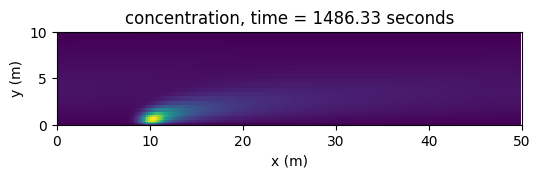

In [8]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf()
    concentration = plt.pcolor(X, Y, c_save[n,:,:].T)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlim(0, L)
    plt.ylim(0, w)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('concentration, time = {0:.2f} seconds'.format(t_save[n]))
    return (concentration,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

## 2.3 Student investigation
<a id='section2pt3'></a>
### Advective/diffusive timescales
In the boxes below, plot the pollution concentration at a few points as a function of time. Then vary the maximum flow speed and the diffusivity and explore how the pollution levels depend on these parameters. Using dimensional analysis, estimate the time needed for the pollution to reach the opposite side of the river. How far downstream of the source do you expect this to happen (assuming that the domain in the x-direction is infinite).

In [9]:
print(c_save.shape)
#c_save =[time, x, y]
# limits L=50, w=10

(78, 256, 32)


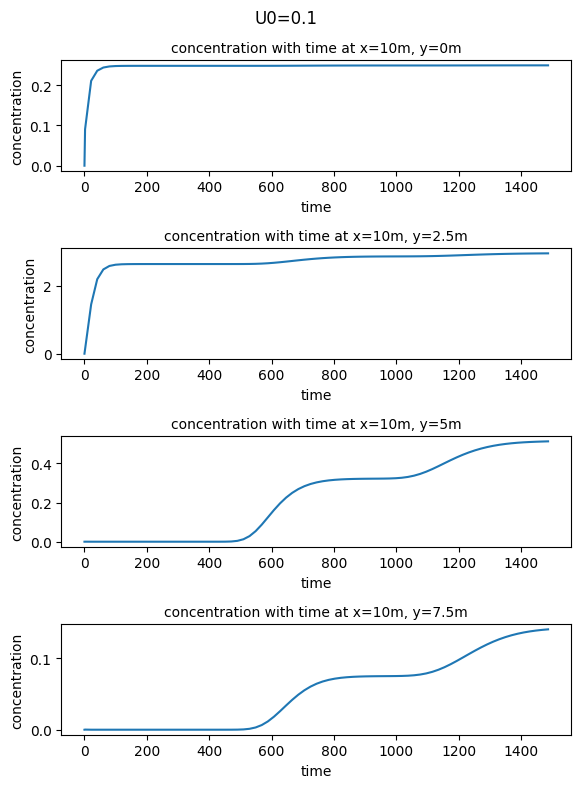

In [25]:
plt.figure(figsize=(6,8))
plt.subplot(4,1,1)
plt.plot(t_save,c_save[:,50,0])
plt.title('concentration with time at x=10m, y=0m', fontsize=10)
plt.xlabel('time')
plt.ylabel('concentration')

plt.subplot(4,1,2)
plt.plot(t_save,c_save[:,50,8])
plt.title('concentration with time at x=10m, y=2.5m', fontsize=10)
plt.xlabel('time')
plt.ylabel('concentration')

plt.subplot(4,1,3)
plt.plot(t_save, c_save[:,50,16])
plt.title('concentration with time at x=10m, y=5m', fontsize=10)
plt.xlabel('time')
plt.ylabel('concentration')

plt.subplot(4,1,4)
plt.plot(t_save, c_save[:,50,24])
plt.title('concentration with time at x=10m, y=7.5m', fontsize=10)
plt.xlabel('time')
plt.ylabel('concentration')

plt.suptitle('U0=0.1')
plt.tight_layout()

plt.show()

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.5e+00/s


2025-11-11 19:54:17,019 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.5e+00/s


INFO:__main__:Starting main loop


2025-11-11 19:54:17,024 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=9.765625e-01, dt=9.765625e-01


2025-11-11 19:54:17,061 __main__ 0/1 INFO :: Iteration=1, Time=9.765625e-01, dt=9.765625e-01


INFO:__main__:Iteration=11, Time=1.074219e+01, dt=9.765625e-01


2025-11-11 19:54:17,085 __main__ 0/1 INFO :: Iteration=11, Time=1.074219e+01, dt=9.765625e-01


INFO:__main__:Iteration=21, Time=2.050781e+01, dt=9.765625e-01


2025-11-11 19:54:17,109 __main__ 0/1 INFO :: Iteration=21, Time=2.050781e+01, dt=9.765625e-01


INFO:__main__:Iteration=31, Time=3.027344e+01, dt=9.765625e-01


2025-11-11 19:54:17,133 __main__ 0/1 INFO :: Iteration=31, Time=3.027344e+01, dt=9.765625e-01


INFO:__main__:Iteration=41, Time=4.003906e+01, dt=9.765625e-01


2025-11-11 19:54:17,157 __main__ 0/1 INFO :: Iteration=41, Time=4.003906e+01, dt=9.765625e-01


INFO:__main__:Iteration=51, Time=4.980469e+01, dt=9.765625e-01


2025-11-11 19:54:17,180 __main__ 0/1 INFO :: Iteration=51, Time=4.980469e+01, dt=9.765625e-01


INFO:__main__:Iteration=61, Time=5.957031e+01, dt=9.765625e-01


2025-11-11 19:54:17,204 __main__ 0/1 INFO :: Iteration=61, Time=5.957031e+01, dt=9.765625e-01


INFO:__main__:Iteration=71, Time=6.933594e+01, dt=9.765625e-01


2025-11-11 19:54:17,228 __main__ 0/1 INFO :: Iteration=71, Time=6.933594e+01, dt=9.765625e-01


INFO:__main__:Iteration=81, Time=7.910156e+01, dt=9.765625e-01


2025-11-11 19:54:17,252 __main__ 0/1 INFO :: Iteration=81, Time=7.910156e+01, dt=9.765625e-01


INFO:__main__:Iteration=91, Time=8.886719e+01, dt=9.765625e-01


2025-11-11 19:54:17,278 __main__ 0/1 INFO :: Iteration=91, Time=8.886719e+01, dt=9.765625e-01


INFO:__main__:Iteration=101, Time=9.863281e+01, dt=9.765625e-01


2025-11-11 19:54:17,305 __main__ 0/1 INFO :: Iteration=101, Time=9.863281e+01, dt=9.765625e-01


INFO:__main__:Iteration=111, Time=1.083984e+02, dt=9.765625e-01


2025-11-11 19:54:17,328 __main__ 0/1 INFO :: Iteration=111, Time=1.083984e+02, dt=9.765625e-01


INFO:__main__:Iteration=121, Time=1.181641e+02, dt=9.765625e-01


2025-11-11 19:54:17,352 __main__ 0/1 INFO :: Iteration=121, Time=1.181641e+02, dt=9.765625e-01


INFO:__main__:Iteration=131, Time=1.279297e+02, dt=9.765625e-01


2025-11-11 19:54:17,375 __main__ 0/1 INFO :: Iteration=131, Time=1.279297e+02, dt=9.765625e-01


INFO:__main__:Iteration=141, Time=1.376953e+02, dt=9.765625e-01


2025-11-11 19:54:17,399 __main__ 0/1 INFO :: Iteration=141, Time=1.376953e+02, dt=9.765625e-01


INFO:__main__:Iteration=151, Time=1.474609e+02, dt=9.765625e-01


2025-11-11 19:54:17,424 __main__ 0/1 INFO :: Iteration=151, Time=1.474609e+02, dt=9.765625e-01


INFO:__main__:Iteration=161, Time=1.572266e+02, dt=9.765625e-01


2025-11-11 19:54:17,448 __main__ 0/1 INFO :: Iteration=161, Time=1.572266e+02, dt=9.765625e-01


INFO:__main__:Iteration=171, Time=1.669922e+02, dt=9.765625e-01


2025-11-11 19:54:17,473 __main__ 0/1 INFO :: Iteration=171, Time=1.669922e+02, dt=9.765625e-01


INFO:__main__:Iteration=181, Time=1.767578e+02, dt=9.765625e-01


2025-11-11 19:54:17,499 __main__ 0/1 INFO :: Iteration=181, Time=1.767578e+02, dt=9.765625e-01


INFO:__main__:Iteration=191, Time=1.865234e+02, dt=9.765625e-01


2025-11-11 19:54:17,524 __main__ 0/1 INFO :: Iteration=191, Time=1.865234e+02, dt=9.765625e-01


INFO:__main__:Iteration=201, Time=1.962891e+02, dt=9.765625e-01


2025-11-11 19:54:17,549 __main__ 0/1 INFO :: Iteration=201, Time=1.962891e+02, dt=9.765625e-01


INFO:__main__:Iteration=211, Time=2.060547e+02, dt=9.765625e-01


2025-11-11 19:54:17,574 __main__ 0/1 INFO :: Iteration=211, Time=2.060547e+02, dt=9.765625e-01


INFO:__main__:Iteration=221, Time=2.158203e+02, dt=9.765625e-01


2025-11-11 19:54:17,598 __main__ 0/1 INFO :: Iteration=221, Time=2.158203e+02, dt=9.765625e-01


INFO:__main__:Iteration=231, Time=2.255859e+02, dt=9.765625e-01


2025-11-11 19:54:17,622 __main__ 0/1 INFO :: Iteration=231, Time=2.255859e+02, dt=9.765625e-01


INFO:__main__:Iteration=241, Time=2.353516e+02, dt=9.765625e-01


2025-11-11 19:54:17,647 __main__ 0/1 INFO :: Iteration=241, Time=2.353516e+02, dt=9.765625e-01


INFO:__main__:Iteration=251, Time=2.451172e+02, dt=9.765625e-01


2025-11-11 19:54:17,672 __main__ 0/1 INFO :: Iteration=251, Time=2.451172e+02, dt=9.765625e-01


INFO:__main__:Iteration=261, Time=2.548828e+02, dt=9.765625e-01


2025-11-11 19:54:17,696 __main__ 0/1 INFO :: Iteration=261, Time=2.548828e+02, dt=9.765625e-01


INFO:__main__:Iteration=271, Time=2.646484e+02, dt=9.765625e-01


2025-11-11 19:54:17,720 __main__ 0/1 INFO :: Iteration=271, Time=2.646484e+02, dt=9.765625e-01


INFO:__main__:Iteration=281, Time=2.744141e+02, dt=9.765625e-01


2025-11-11 19:54:17,744 __main__ 0/1 INFO :: Iteration=281, Time=2.744141e+02, dt=9.765625e-01


INFO:__main__:Iteration=291, Time=2.841797e+02, dt=9.765625e-01


2025-11-11 19:54:17,768 __main__ 0/1 INFO :: Iteration=291, Time=2.841797e+02, dt=9.765625e-01


INFO:__main__:Iteration=301, Time=2.939453e+02, dt=9.765625e-01


2025-11-11 19:54:17,794 __main__ 0/1 INFO :: Iteration=301, Time=2.939453e+02, dt=9.765625e-01


INFO:__main__:Iteration=311, Time=3.037109e+02, dt=9.765625e-01


2025-11-11 19:54:17,819 __main__ 0/1 INFO :: Iteration=311, Time=3.037109e+02, dt=9.765625e-01


INFO:__main__:Iteration=321, Time=3.134766e+02, dt=9.765625e-01


2025-11-11 19:54:17,857 __main__ 0/1 INFO :: Iteration=321, Time=3.134766e+02, dt=9.765625e-01


INFO:__main__:Iteration=331, Time=3.232422e+02, dt=9.765625e-01


2025-11-11 19:54:17,884 __main__ 0/1 INFO :: Iteration=331, Time=3.232422e+02, dt=9.765625e-01


INFO:__main__:Iteration=341, Time=3.330078e+02, dt=9.765625e-01


2025-11-11 19:54:17,909 __main__ 0/1 INFO :: Iteration=341, Time=3.330078e+02, dt=9.765625e-01


INFO:__main__:Iteration=351, Time=3.427734e+02, dt=9.765625e-01


2025-11-11 19:54:17,933 __main__ 0/1 INFO :: Iteration=351, Time=3.427734e+02, dt=9.765625e-01


INFO:__main__:Iteration=361, Time=3.525391e+02, dt=9.765625e-01


2025-11-11 19:54:17,957 __main__ 0/1 INFO :: Iteration=361, Time=3.525391e+02, dt=9.765625e-01


INFO:__main__:Iteration=371, Time=3.623047e+02, dt=9.765625e-01


2025-11-11 19:54:17,982 __main__ 0/1 INFO :: Iteration=371, Time=3.623047e+02, dt=9.765625e-01


INFO:__main__:Iteration=381, Time=3.720703e+02, dt=9.765625e-01


2025-11-11 19:54:18,007 __main__ 0/1 INFO :: Iteration=381, Time=3.720703e+02, dt=9.765625e-01


INFO:__main__:Iteration=391, Time=3.818359e+02, dt=9.765625e-01


2025-11-11 19:54:18,034 __main__ 0/1 INFO :: Iteration=391, Time=3.818359e+02, dt=9.765625e-01


INFO:__main__:Iteration=401, Time=3.916016e+02, dt=9.765625e-01


2025-11-11 19:54:18,060 __main__ 0/1 INFO :: Iteration=401, Time=3.916016e+02, dt=9.765625e-01


INFO:__main__:Iteration=411, Time=4.013672e+02, dt=9.765625e-01


2025-11-11 19:54:18,086 __main__ 0/1 INFO :: Iteration=411, Time=4.013672e+02, dt=9.765625e-01


INFO:__main__:Iteration=421, Time=4.111328e+02, dt=9.765625e-01


2025-11-11 19:54:18,116 __main__ 0/1 INFO :: Iteration=421, Time=4.111328e+02, dt=9.765625e-01


INFO:__main__:Iteration=431, Time=4.208984e+02, dt=9.765625e-01


2025-11-11 19:54:18,142 __main__ 0/1 INFO :: Iteration=431, Time=4.208984e+02, dt=9.765625e-01


INFO:__main__:Iteration=441, Time=4.306641e+02, dt=9.765625e-01


2025-11-11 19:54:18,166 __main__ 0/1 INFO :: Iteration=441, Time=4.306641e+02, dt=9.765625e-01


INFO:__main__:Iteration=451, Time=4.404297e+02, dt=9.765625e-01


2025-11-11 19:54:18,191 __main__ 0/1 INFO :: Iteration=451, Time=4.404297e+02, dt=9.765625e-01


INFO:__main__:Iteration=461, Time=4.501953e+02, dt=9.765625e-01


2025-11-11 19:54:18,216 __main__ 0/1 INFO :: Iteration=461, Time=4.501953e+02, dt=9.765625e-01


INFO:__main__:Iteration=471, Time=4.599609e+02, dt=9.765625e-01


2025-11-11 19:54:18,240 __main__ 0/1 INFO :: Iteration=471, Time=4.599609e+02, dt=9.765625e-01


INFO:__main__:Iteration=481, Time=4.697266e+02, dt=9.765625e-01


2025-11-11 19:54:18,264 __main__ 0/1 INFO :: Iteration=481, Time=4.697266e+02, dt=9.765625e-01


INFO:__main__:Iteration=491, Time=4.794922e+02, dt=9.765625e-01


2025-11-11 19:54:18,291 __main__ 0/1 INFO :: Iteration=491, Time=4.794922e+02, dt=9.765625e-01


INFO:__main__:Iteration=501, Time=4.892578e+02, dt=9.765625e-01


2025-11-11 19:54:18,316 __main__ 0/1 INFO :: Iteration=501, Time=4.892578e+02, dt=9.765625e-01


INFO:__main__:Iteration=511, Time=4.990234e+02, dt=9.765625e-01


2025-11-11 19:54:18,340 __main__ 0/1 INFO :: Iteration=511, Time=4.990234e+02, dt=9.765625e-01


INFO:__main__:Iteration=521, Time=5.087891e+02, dt=9.765625e-01


2025-11-11 19:54:18,365 __main__ 0/1 INFO :: Iteration=521, Time=5.087891e+02, dt=9.765625e-01


INFO:__main__:Iteration=531, Time=5.185547e+02, dt=9.765625e-01


2025-11-11 19:54:18,389 __main__ 0/1 INFO :: Iteration=531, Time=5.185547e+02, dt=9.765625e-01


INFO:__main__:Iteration=541, Time=5.283203e+02, dt=9.765625e-01


2025-11-11 19:54:18,413 __main__ 0/1 INFO :: Iteration=541, Time=5.283203e+02, dt=9.765625e-01


INFO:__main__:Iteration=551, Time=5.380859e+02, dt=9.765625e-01


2025-11-11 19:54:18,438 __main__ 0/1 INFO :: Iteration=551, Time=5.380859e+02, dt=9.765625e-01


INFO:__main__:Iteration=561, Time=5.478516e+02, dt=9.765625e-01


2025-11-11 19:54:18,463 __main__ 0/1 INFO :: Iteration=561, Time=5.478516e+02, dt=9.765625e-01


INFO:__main__:Iteration=571, Time=5.576172e+02, dt=9.765625e-01


2025-11-11 19:54:18,486 __main__ 0/1 INFO :: Iteration=571, Time=5.576172e+02, dt=9.765625e-01


INFO:__main__:Iteration=581, Time=5.673828e+02, dt=9.765625e-01


2025-11-11 19:54:18,512 __main__ 0/1 INFO :: Iteration=581, Time=5.673828e+02, dt=9.765625e-01


INFO:__main__:Iteration=591, Time=5.771484e+02, dt=9.765625e-01


2025-11-11 19:54:18,536 __main__ 0/1 INFO :: Iteration=591, Time=5.771484e+02, dt=9.765625e-01


INFO:__main__:Iteration=601, Time=5.869141e+02, dt=9.765625e-01


2025-11-11 19:54:18,561 __main__ 0/1 INFO :: Iteration=601, Time=5.869141e+02, dt=9.765625e-01


INFO:__main__:Iteration=611, Time=5.966797e+02, dt=9.765625e-01


2025-11-11 19:54:18,585 __main__ 0/1 INFO :: Iteration=611, Time=5.966797e+02, dt=9.765625e-01


INFO:__main__:Iteration=621, Time=6.064453e+02, dt=9.765625e-01


2025-11-11 19:54:18,610 __main__ 0/1 INFO :: Iteration=621, Time=6.064453e+02, dt=9.765625e-01


INFO:__main__:Iteration=631, Time=6.162109e+02, dt=9.765625e-01


2025-11-11 19:54:18,637 __main__ 0/1 INFO :: Iteration=631, Time=6.162109e+02, dt=9.765625e-01


INFO:__main__:Iteration=641, Time=6.259766e+02, dt=9.765625e-01


2025-11-11 19:54:18,661 __main__ 0/1 INFO :: Iteration=641, Time=6.259766e+02, dt=9.765625e-01


INFO:__main__:Iteration=651, Time=6.357422e+02, dt=9.765625e-01


2025-11-11 19:54:18,685 __main__ 0/1 INFO :: Iteration=651, Time=6.357422e+02, dt=9.765625e-01


INFO:__main__:Iteration=661, Time=6.455078e+02, dt=9.765625e-01


2025-11-11 19:54:18,710 __main__ 0/1 INFO :: Iteration=661, Time=6.455078e+02, dt=9.765625e-01


INFO:__main__:Iteration=671, Time=6.552734e+02, dt=9.765625e-01


2025-11-11 19:54:18,734 __main__ 0/1 INFO :: Iteration=671, Time=6.552734e+02, dt=9.765625e-01


INFO:__main__:Iteration=681, Time=6.650391e+02, dt=9.765625e-01


2025-11-11 19:54:18,759 __main__ 0/1 INFO :: Iteration=681, Time=6.650391e+02, dt=9.765625e-01


INFO:__main__:Iteration=691, Time=6.748047e+02, dt=9.765625e-01


2025-11-11 19:54:18,783 __main__ 0/1 INFO :: Iteration=691, Time=6.748047e+02, dt=9.765625e-01


INFO:__main__:Iteration=701, Time=6.845703e+02, dt=9.765625e-01


2025-11-11 19:54:18,808 __main__ 0/1 INFO :: Iteration=701, Time=6.845703e+02, dt=9.765625e-01


INFO:__main__:Iteration=711, Time=6.943359e+02, dt=9.765625e-01


2025-11-11 19:54:18,833 __main__ 0/1 INFO :: Iteration=711, Time=6.943359e+02, dt=9.765625e-01


INFO:__main__:Iteration=721, Time=7.041016e+02, dt=9.765625e-01


2025-11-11 19:54:18,857 __main__ 0/1 INFO :: Iteration=721, Time=7.041016e+02, dt=9.765625e-01


INFO:__main__:Iteration=731, Time=7.138672e+02, dt=9.765625e-01


2025-11-11 19:54:18,894 __main__ 0/1 INFO :: Iteration=731, Time=7.138672e+02, dt=9.765625e-01


INFO:__main__:Iteration=741, Time=7.236328e+02, dt=9.765625e-01


2025-11-11 19:54:18,922 __main__ 0/1 INFO :: Iteration=741, Time=7.236328e+02, dt=9.765625e-01


INFO:__main__:Iteration=751, Time=7.333984e+02, dt=9.765625e-01


2025-11-11 19:54:18,947 __main__ 0/1 INFO :: Iteration=751, Time=7.333984e+02, dt=9.765625e-01


INFO:__main__:Iteration=761, Time=7.431641e+02, dt=9.765625e-01


2025-11-11 19:54:18,971 __main__ 0/1 INFO :: Iteration=761, Time=7.431641e+02, dt=9.765625e-01


INFO:__main__:Iteration=771, Time=7.529297e+02, dt=9.765625e-01


2025-11-11 19:54:18,995 __main__ 0/1 INFO :: Iteration=771, Time=7.529297e+02, dt=9.765625e-01


INFO:__main__:Iteration=781, Time=7.626953e+02, dt=9.765625e-01


2025-11-11 19:54:19,020 __main__ 0/1 INFO :: Iteration=781, Time=7.626953e+02, dt=9.765625e-01


INFO:__main__:Iteration=791, Time=7.724609e+02, dt=9.765625e-01


2025-11-11 19:54:19,044 __main__ 0/1 INFO :: Iteration=791, Time=7.724609e+02, dt=9.765625e-01


INFO:__main__:Iteration=801, Time=7.822266e+02, dt=9.765625e-01


2025-11-11 19:54:19,070 __main__ 0/1 INFO :: Iteration=801, Time=7.822266e+02, dt=9.765625e-01


INFO:__main__:Iteration=811, Time=7.919922e+02, dt=9.765625e-01


2025-11-11 19:54:19,095 __main__ 0/1 INFO :: Iteration=811, Time=7.919922e+02, dt=9.765625e-01


INFO:__main__:Iteration=821, Time=8.017578e+02, dt=9.765625e-01


2025-11-11 19:54:19,119 __main__ 0/1 INFO :: Iteration=821, Time=8.017578e+02, dt=9.765625e-01


INFO:__main__:Iteration=831, Time=8.115234e+02, dt=9.765625e-01


2025-11-11 19:54:19,145 __main__ 0/1 INFO :: Iteration=831, Time=8.115234e+02, dt=9.765625e-01


INFO:__main__:Iteration=841, Time=8.212891e+02, dt=9.765625e-01


2025-11-11 19:54:19,174 __main__ 0/1 INFO :: Iteration=841, Time=8.212891e+02, dt=9.765625e-01


INFO:__main__:Iteration=851, Time=8.310547e+02, dt=9.765625e-01


2025-11-11 19:54:19,201 __main__ 0/1 INFO :: Iteration=851, Time=8.310547e+02, dt=9.765625e-01


INFO:__main__:Iteration=861, Time=8.408203e+02, dt=9.765625e-01


2025-11-11 19:54:19,226 __main__ 0/1 INFO :: Iteration=861, Time=8.408203e+02, dt=9.765625e-01


INFO:__main__:Iteration=871, Time=8.505859e+02, dt=9.765625e-01


2025-11-11 19:54:19,252 __main__ 0/1 INFO :: Iteration=871, Time=8.505859e+02, dt=9.765625e-01


INFO:__main__:Iteration=881, Time=8.603516e+02, dt=9.765625e-01


2025-11-11 19:54:19,277 __main__ 0/1 INFO :: Iteration=881, Time=8.603516e+02, dt=9.765625e-01


INFO:__main__:Iteration=891, Time=8.701172e+02, dt=9.765625e-01


2025-11-11 19:54:19,304 __main__ 0/1 INFO :: Iteration=891, Time=8.701172e+02, dt=9.765625e-01


INFO:__main__:Iteration=901, Time=8.798828e+02, dt=9.765625e-01


2025-11-11 19:54:19,329 __main__ 0/1 INFO :: Iteration=901, Time=8.798828e+02, dt=9.765625e-01


INFO:__main__:Iteration=911, Time=8.896484e+02, dt=9.765625e-01


2025-11-11 19:54:19,355 __main__ 0/1 INFO :: Iteration=911, Time=8.896484e+02, dt=9.765625e-01


INFO:__main__:Iteration=921, Time=8.994141e+02, dt=9.765625e-01


2025-11-11 19:54:19,379 __main__ 0/1 INFO :: Iteration=921, Time=8.994141e+02, dt=9.765625e-01


INFO:__main__:Iteration=931, Time=9.091797e+02, dt=9.765625e-01


2025-11-11 19:54:19,404 __main__ 0/1 INFO :: Iteration=931, Time=9.091797e+02, dt=9.765625e-01


INFO:__main__:Iteration=941, Time=9.189453e+02, dt=9.765625e-01


2025-11-11 19:54:19,431 __main__ 0/1 INFO :: Iteration=941, Time=9.189453e+02, dt=9.765625e-01


INFO:__main__:Iteration=951, Time=9.287109e+02, dt=9.765625e-01


2025-11-11 19:54:19,455 __main__ 0/1 INFO :: Iteration=951, Time=9.287109e+02, dt=9.765625e-01


INFO:__main__:Iteration=961, Time=9.384766e+02, dt=9.765625e-01


2025-11-11 19:54:19,481 __main__ 0/1 INFO :: Iteration=961, Time=9.384766e+02, dt=9.765625e-01


INFO:__main__:Iteration=971, Time=9.482422e+02, dt=9.765625e-01


2025-11-11 19:54:19,508 __main__ 0/1 INFO :: Iteration=971, Time=9.482422e+02, dt=9.765625e-01


INFO:__main__:Iteration=981, Time=9.580078e+02, dt=9.765625e-01


2025-11-11 19:54:19,534 __main__ 0/1 INFO :: Iteration=981, Time=9.580078e+02, dt=9.765625e-01


INFO:__main__:Iteration=991, Time=9.677734e+02, dt=9.765625e-01


2025-11-11 19:54:19,560 __main__ 0/1 INFO :: Iteration=991, Time=9.677734e+02, dt=9.765625e-01


INFO:__main__:Iteration=1001, Time=9.775391e+02, dt=9.765625e-01


2025-11-11 19:54:19,586 __main__ 0/1 INFO :: Iteration=1001, Time=9.775391e+02, dt=9.765625e-01


INFO:__main__:Iteration=1011, Time=9.873047e+02, dt=9.765625e-01


2025-11-11 19:54:19,611 __main__ 0/1 INFO :: Iteration=1011, Time=9.873047e+02, dt=9.765625e-01


INFO:__main__:Iteration=1021, Time=9.970703e+02, dt=9.765625e-01


2025-11-11 19:54:19,637 __main__ 0/1 INFO :: Iteration=1021, Time=9.970703e+02, dt=9.765625e-01


INFO:__main__:Iteration=1031, Time=1.006836e+03, dt=9.765625e-01


2025-11-11 19:54:19,663 __main__ 0/1 INFO :: Iteration=1031, Time=1.006836e+03, dt=9.765625e-01


INFO:__main__:Iteration=1041, Time=1.016602e+03, dt=9.765625e-01


2025-11-11 19:54:19,691 __main__ 0/1 INFO :: Iteration=1041, Time=1.016602e+03, dt=9.765625e-01


INFO:__main__:Iteration=1051, Time=1.026367e+03, dt=9.765625e-01


2025-11-11 19:54:19,717 __main__ 0/1 INFO :: Iteration=1051, Time=1.026367e+03, dt=9.765625e-01


INFO:__main__:Iteration=1061, Time=1.036133e+03, dt=9.765625e-01


2025-11-11 19:54:19,743 __main__ 0/1 INFO :: Iteration=1061, Time=1.036133e+03, dt=9.765625e-01


INFO:__main__:Iteration=1071, Time=1.045898e+03, dt=9.765625e-01


2025-11-11 19:54:19,768 __main__ 0/1 INFO :: Iteration=1071, Time=1.045898e+03, dt=9.765625e-01


INFO:__main__:Iteration=1081, Time=1.055664e+03, dt=9.765625e-01


2025-11-11 19:54:19,792 __main__ 0/1 INFO :: Iteration=1081, Time=1.055664e+03, dt=9.765625e-01


INFO:__main__:Iteration=1091, Time=1.065430e+03, dt=9.765625e-01


2025-11-11 19:54:19,818 __main__ 0/1 INFO :: Iteration=1091, Time=1.065430e+03, dt=9.765625e-01


INFO:__main__:Iteration=1101, Time=1.075195e+03, dt=9.765625e-01


2025-11-11 19:54:19,844 __main__ 0/1 INFO :: Iteration=1101, Time=1.075195e+03, dt=9.765625e-01


INFO:__main__:Iteration=1111, Time=1.084961e+03, dt=9.765625e-01


2025-11-11 19:54:19,869 __main__ 0/1 INFO :: Iteration=1111, Time=1.084961e+03, dt=9.765625e-01


INFO:__main__:Iteration=1121, Time=1.094727e+03, dt=9.765625e-01


2025-11-11 19:54:19,895 __main__ 0/1 INFO :: Iteration=1121, Time=1.094727e+03, dt=9.765625e-01


INFO:__main__:Iteration=1131, Time=1.104492e+03, dt=9.765625e-01


2025-11-11 19:54:19,936 __main__ 0/1 INFO :: Iteration=1131, Time=1.104492e+03, dt=9.765625e-01


INFO:__main__:Iteration=1141, Time=1.114258e+03, dt=9.765625e-01


2025-11-11 19:54:19,963 __main__ 0/1 INFO :: Iteration=1141, Time=1.114258e+03, dt=9.765625e-01


INFO:__main__:Iteration=1151, Time=1.124023e+03, dt=9.765625e-01


2025-11-11 19:54:19,988 __main__ 0/1 INFO :: Iteration=1151, Time=1.124023e+03, dt=9.765625e-01


INFO:__main__:Iteration=1161, Time=1.133789e+03, dt=9.765625e-01


2025-11-11 19:54:20,013 __main__ 0/1 INFO :: Iteration=1161, Time=1.133789e+03, dt=9.765625e-01


INFO:__main__:Iteration=1171, Time=1.143555e+03, dt=9.765625e-01


2025-11-11 19:54:20,038 __main__ 0/1 INFO :: Iteration=1171, Time=1.143555e+03, dt=9.765625e-01


INFO:__main__:Iteration=1181, Time=1.153320e+03, dt=9.765625e-01


2025-11-11 19:54:20,064 __main__ 0/1 INFO :: Iteration=1181, Time=1.153320e+03, dt=9.765625e-01


INFO:__main__:Iteration=1191, Time=1.163086e+03, dt=9.765625e-01


2025-11-11 19:54:20,090 __main__ 0/1 INFO :: Iteration=1191, Time=1.163086e+03, dt=9.765625e-01


INFO:__main__:Iteration=1201, Time=1.172852e+03, dt=9.765625e-01


2025-11-11 19:54:20,116 __main__ 0/1 INFO :: Iteration=1201, Time=1.172852e+03, dt=9.765625e-01


INFO:__main__:Iteration=1211, Time=1.182617e+03, dt=9.765625e-01


2025-11-11 19:54:20,143 __main__ 0/1 INFO :: Iteration=1211, Time=1.182617e+03, dt=9.765625e-01


INFO:__main__:Iteration=1221, Time=1.192383e+03, dt=9.765625e-01


2025-11-11 19:54:20,169 __main__ 0/1 INFO :: Iteration=1221, Time=1.192383e+03, dt=9.765625e-01


INFO:__main__:Iteration=1231, Time=1.202148e+03, dt=9.765625e-01


2025-11-11 19:54:20,194 __main__ 0/1 INFO :: Iteration=1231, Time=1.202148e+03, dt=9.765625e-01


INFO:__main__:Iteration=1241, Time=1.211914e+03, dt=9.765625e-01


2025-11-11 19:54:20,225 __main__ 0/1 INFO :: Iteration=1241, Time=1.211914e+03, dt=9.765625e-01


INFO:__main__:Iteration=1251, Time=1.221680e+03, dt=9.765625e-01


2025-11-11 19:54:20,252 __main__ 0/1 INFO :: Iteration=1251, Time=1.221680e+03, dt=9.765625e-01


INFO:__main__:Iteration=1261, Time=1.231445e+03, dt=9.765625e-01


2025-11-11 19:54:20,278 __main__ 0/1 INFO :: Iteration=1261, Time=1.231445e+03, dt=9.765625e-01


INFO:__main__:Iteration=1271, Time=1.241211e+03, dt=9.765625e-01


2025-11-11 19:54:20,305 __main__ 0/1 INFO :: Iteration=1271, Time=1.241211e+03, dt=9.765625e-01


INFO:__main__:Iteration=1281, Time=1.250977e+03, dt=9.765625e-01


2025-11-11 19:54:20,331 __main__ 0/1 INFO :: Iteration=1281, Time=1.250977e+03, dt=9.765625e-01


INFO:__main__:Iteration=1291, Time=1.260742e+03, dt=9.765625e-01


2025-11-11 19:54:20,356 __main__ 0/1 INFO :: Iteration=1291, Time=1.260742e+03, dt=9.765625e-01


INFO:__main__:Iteration=1301, Time=1.270508e+03, dt=9.765625e-01


2025-11-11 19:54:20,383 __main__ 0/1 INFO :: Iteration=1301, Time=1.270508e+03, dt=9.765625e-01


INFO:__main__:Iteration=1311, Time=1.280273e+03, dt=9.765625e-01


2025-11-11 19:54:20,412 __main__ 0/1 INFO :: Iteration=1311, Time=1.280273e+03, dt=9.765625e-01


INFO:__main__:Iteration=1321, Time=1.290039e+03, dt=9.765625e-01


2025-11-11 19:54:20,437 __main__ 0/1 INFO :: Iteration=1321, Time=1.290039e+03, dt=9.765625e-01


INFO:__main__:Iteration=1331, Time=1.299805e+03, dt=9.765625e-01


2025-11-11 19:54:20,463 __main__ 0/1 INFO :: Iteration=1331, Time=1.299805e+03, dt=9.765625e-01


INFO:__main__:Iteration=1341, Time=1.309570e+03, dt=9.765625e-01


2025-11-11 19:54:20,493 __main__ 0/1 INFO :: Iteration=1341, Time=1.309570e+03, dt=9.765625e-01


INFO:__main__:Iteration=1351, Time=1.319336e+03, dt=9.765625e-01


2025-11-11 19:54:20,520 __main__ 0/1 INFO :: Iteration=1351, Time=1.319336e+03, dt=9.765625e-01


INFO:__main__:Iteration=1361, Time=1.329102e+03, dt=9.765625e-01


2025-11-11 19:54:20,547 __main__ 0/1 INFO :: Iteration=1361, Time=1.329102e+03, dt=9.765625e-01


INFO:__main__:Iteration=1371, Time=1.338867e+03, dt=9.765625e-01


2025-11-11 19:54:20,573 __main__ 0/1 INFO :: Iteration=1371, Time=1.338867e+03, dt=9.765625e-01


INFO:__main__:Iteration=1381, Time=1.348633e+03, dt=9.765625e-01


2025-11-11 19:54:20,599 __main__ 0/1 INFO :: Iteration=1381, Time=1.348633e+03, dt=9.765625e-01


INFO:__main__:Iteration=1391, Time=1.358398e+03, dt=9.765625e-01


2025-11-11 19:54:20,626 __main__ 0/1 INFO :: Iteration=1391, Time=1.358398e+03, dt=9.765625e-01


INFO:__main__:Iteration=1401, Time=1.368164e+03, dt=9.765625e-01


2025-11-11 19:54:20,652 __main__ 0/1 INFO :: Iteration=1401, Time=1.368164e+03, dt=9.765625e-01


INFO:__main__:Iteration=1411, Time=1.377930e+03, dt=9.765625e-01


2025-11-11 19:54:20,679 __main__ 0/1 INFO :: Iteration=1411, Time=1.377930e+03, dt=9.765625e-01


INFO:__main__:Iteration=1421, Time=1.387695e+03, dt=9.765625e-01


2025-11-11 19:54:20,704 __main__ 0/1 INFO :: Iteration=1421, Time=1.387695e+03, dt=9.765625e-01


INFO:__main__:Iteration=1431, Time=1.397461e+03, dt=9.765625e-01


2025-11-11 19:54:20,730 __main__ 0/1 INFO :: Iteration=1431, Time=1.397461e+03, dt=9.765625e-01


INFO:__main__:Iteration=1441, Time=1.407227e+03, dt=9.765625e-01


2025-11-11 19:54:20,758 __main__ 0/1 INFO :: Iteration=1441, Time=1.407227e+03, dt=9.765625e-01


INFO:__main__:Iteration=1451, Time=1.416992e+03, dt=9.765625e-01


2025-11-11 19:54:20,783 __main__ 0/1 INFO :: Iteration=1451, Time=1.416992e+03, dt=9.765625e-01


INFO:__main__:Iteration=1461, Time=1.426758e+03, dt=9.765625e-01


2025-11-11 19:54:20,810 __main__ 0/1 INFO :: Iteration=1461, Time=1.426758e+03, dt=9.765625e-01


INFO:__main__:Iteration=1471, Time=1.436523e+03, dt=9.765625e-01


2025-11-11 19:54:20,838 __main__ 0/1 INFO :: Iteration=1471, Time=1.436523e+03, dt=9.765625e-01


INFO:__main__:Iteration=1481, Time=1.446289e+03, dt=9.765625e-01


2025-11-11 19:54:20,863 __main__ 0/1 INFO :: Iteration=1481, Time=1.446289e+03, dt=9.765625e-01


INFO:__main__:Iteration=1491, Time=1.456055e+03, dt=9.765625e-01


2025-11-11 19:54:20,889 __main__ 0/1 INFO :: Iteration=1491, Time=1.456055e+03, dt=9.765625e-01


INFO:__main__:Iteration=1501, Time=1.465820e+03, dt=9.765625e-01


2025-11-11 19:54:20,915 __main__ 0/1 INFO :: Iteration=1501, Time=1.465820e+03, dt=9.765625e-01


INFO:__main__:Iteration=1511, Time=1.475586e+03, dt=9.765625e-01


2025-11-11 19:54:20,945 __main__ 0/1 INFO :: Iteration=1511, Time=1.475586e+03, dt=9.765625e-01


INFO:__main__:Iteration=1521, Time=1.485352e+03, dt=9.765625e-01


2025-11-11 19:54:20,980 __main__ 0/1 INFO :: Iteration=1521, Time=1.485352e+03, dt=9.765625e-01


INFO:__main__:Iteration=1531, Time=1.495117e+03, dt=9.765625e-01


2025-11-11 19:54:21,010 __main__ 0/1 INFO :: Iteration=1531, Time=1.495117e+03, dt=9.765625e-01


INFO:solvers:Simulation stop time reached.


2025-11-11 19:54:21,026 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 1536


2025-11-11 19:54:21,029 solvers 0/1 INFO :: Final iteration: 1536


INFO:solvers:Final sim time: 1500.0


2025-11-11 19:54:21,030 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.2302 sec


2025-11-11 19:54:21,033 solvers 0/1 INFO :: Setup time (init - iter 0): 0.2302 sec


INFO:solvers:Warmup time (iter 0-10): 0.05683 sec


2025-11-11 19:54:21,034 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.05683 sec


INFO:solvers:Run time (iter 10-end): 3.945 sec


2025-11-11 19:54:21,037 solvers 0/1 INFO :: Run time (iter 10-end): 3.945 sec


INFO:solvers:CPU time (iter 10-end): 0.001096 cpu-hr


2025-11-11 19:54:21,041 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001096 cpu-hr


INFO:solvers:Speed: 6.707e+06 mode-stages/cpu-sec


2025-11-11 19:54:21,042 solvers 0/1 INFO :: Speed: 6.707e+06 mode-stages/cpu-sec


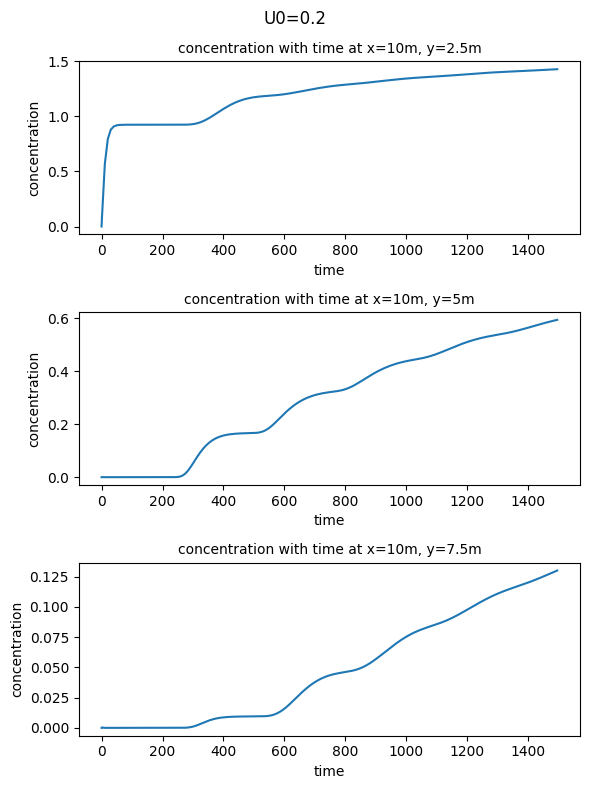

In [26]:
#U0=0.2, Kappa= unchanged
U0 = 0.2 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='c', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

plt.figure(figsize=(6,8))

plt.subplot(3,1,1)
plt.plot(t_save,c_save[:,50,8])
plt.title('concentration with time at x=10m, y=2.5m', fontsize=10)
plt.xlabel('time')
plt.ylabel('concentration')

plt.subplot(3,1,2)
plt.plot(t_save, c_save[:,50,16])
plt.title('concentration with time at x=10m, y=5m', fontsize=10)
plt.xlabel('time')
plt.ylabel('concentration')

plt.subplot(3,1,3)
plt.plot(t_save, c_save[:,50,24])
plt.title('concentration with time at x=10m, y=7.5m', fontsize=10)
plt.xlabel('time')
plt.ylabel('concentration')

plt.suptitle('U0=0.2')
plt.tight_layout()

plt.show()

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2025-11-11 19:54:41,601 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


INFO:__main__:Starting main loop


2025-11-11 19:54:41,608 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2025-11-11 19:54:41,645 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2025-11-11 19:54:41,669 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2025-11-11 19:54:41,692 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2025-11-11 19:54:41,715 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2025-11-11 19:54:41,739 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2025-11-11 19:54:41,762 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2025-11-11 19:54:41,786 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2025-11-11 19:54:41,810 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2025-11-11 19:54:41,833 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2025-11-11 19:54:41,856 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2025-11-11 19:54:41,883 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2025-11-11 19:54:41,907 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2025-11-11 19:54:41,931 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2025-11-11 19:54:41,957 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2025-11-11 19:54:41,981 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2025-11-11 19:54:42,006 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2025-11-11 19:54:42,030 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2025-11-11 19:54:42,054 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2025-11-11 19:54:42,078 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2025-11-11 19:54:42,106 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2025-11-11 19:54:42,137 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2025-11-11 19:54:42,162 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2025-11-11 19:54:42,187 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2025-11-11 19:54:42,212 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2025-11-11 19:54:42,236 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2025-11-11 19:54:42,261 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2025-11-11 19:54:42,285 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2025-11-11 19:54:42,309 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2025-11-11 19:54:42,333 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2025-11-11 19:54:42,358 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2025-11-11 19:54:42,386 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2025-11-11 19:54:42,412 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2025-11-11 19:54:42,437 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2025-11-11 19:54:42,462 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2025-11-11 19:54:42,486 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2025-11-11 19:54:42,517 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2025-11-11 19:54:42,551 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2025-11-11 19:54:42,574 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2025-11-11 19:54:42,599 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2025-11-11 19:54:42,624 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2025-11-11 19:54:42,651 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2025-11-11 19:54:42,676 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2025-11-11 19:54:42,700 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2025-11-11 19:54:42,726 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2025-11-11 19:54:42,750 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2025-11-11 19:54:42,775 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2025-11-11 19:54:42,799 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2025-11-11 19:54:42,823 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2025-11-11 19:54:42,848 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2025-11-11 19:54:42,871 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2025-11-11 19:54:42,897 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2025-11-11 19:54:42,924 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2025-11-11 19:54:42,948 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2025-11-11 19:54:42,972 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2025-11-11 19:54:42,997 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2025-11-11 19:54:43,021 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2025-11-11 19:54:43,048 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2025-11-11 19:54:43,072 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2025-11-11 19:54:43,096 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2025-11-11 19:54:43,121 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2025-11-11 19:54:43,145 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2025-11-11 19:54:43,175 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2025-11-11 19:54:43,200 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2025-11-11 19:54:43,225 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2025-11-11 19:54:43,250 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2025-11-11 19:54:43,277 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2025-11-11 19:54:43,302 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2025-11-11 19:54:43,326 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2025-11-11 19:54:43,351 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2025-11-11 19:54:43,376 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2025-11-11 19:54:43,406 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2025-11-11 19:54:43,435 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2025-11-11 19:54:43,460 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2025-11-11 19:54:43,485 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2025-11-11 19:54:43,513 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2025-11-11 19:54:43,540 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2025-11-11 19:54:43,572 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2025-11-11 19:54:43,596 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2025-11-11 19:54:43,598 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2025-11-11 19:54:43,599 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.2465 sec


2025-11-11 19:54:43,600 solvers 0/1 INFO :: Setup time (init - iter 0): 0.2465 sec


INFO:solvers:Warmup time (iter 0-10): 0.05592 sec


2025-11-11 19:54:43,601 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.05592 sec


INFO:solvers:Run time (iter 10-end): 1.931 sec


2025-11-11 19:54:43,604 solvers 0/1 INFO :: Run time (iter 10-end): 1.931 sec


INFO:solvers:CPU time (iter 10-end): 0.0005363 cpu-hr


2025-11-11 19:54:43,606 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0005363 cpu-hr


INFO:solvers:Speed: 6.807e+06 mode-stages/cpu-sec


2025-11-11 19:54:43,607 solvers 0/1 INFO :: Speed: 6.807e+06 mode-stages/cpu-sec


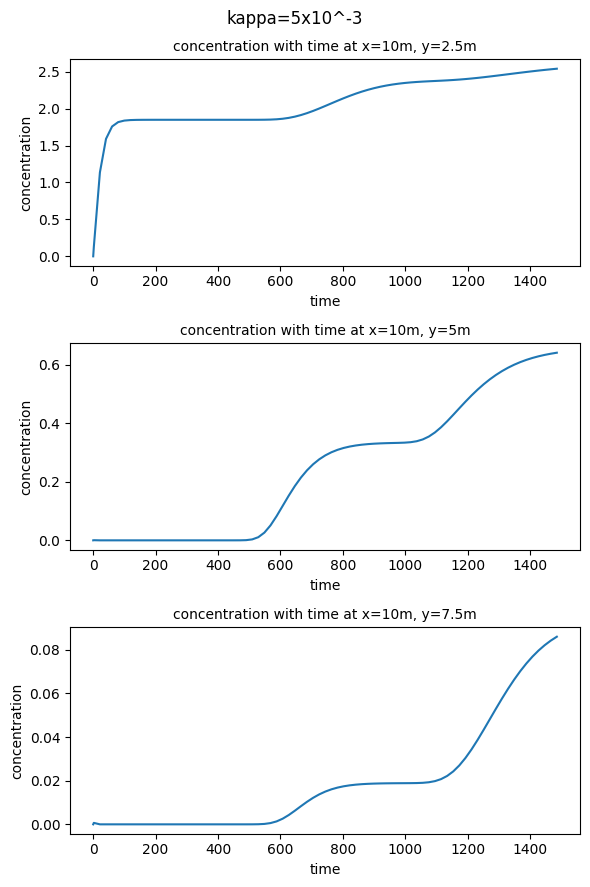

In [27]:
# U0=0.1,  kappa = 5e-3
U0 = 0.1 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 5e-3 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='c', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

plt.figure(figsize=(6,9))

plt.subplot(3,1,1)
plt.plot(t_save,c_save[:,50,8])
plt.title('concentration with time at x=10m, y=2.5m', fontsize=10)
plt.xlabel('time')
plt.ylabel('concentration')

plt.subplot(3,1,2)
plt.plot(t_save, c_save[:,50,16])
plt.title('concentration with time at x=10m, y=5m', fontsize=10)
plt.xlabel('time')
plt.ylabel('concentration')

plt.subplot(3,1,3)
plt.plot(t_save, c_save[:,50,24])
plt.title('concentration with time at x=10m, y=7.5m', fontsize=10)
plt.xlabel('time')
plt.ylabel('concentration')

plt.suptitle('kappa=5x10^-3')
plt.tight_layout()

plt.show()

Scaling analysis:
using the advection diffusion equation:
$$ \frac{\partial c}{\partial t} + u(y)\frac{\partial c}{\partial x} = \kappa \nabla^2 c + S(x,y) $$
where we can ignore source term S at scales of y=w, the 4 remaining terms scale like
$$ \frac{c}{t} , u \frac{c}{x} , \kappa \frac{c}{x^2}  , \kappa \frac{c}{y^2}  $$
From equation of u(y) in section 2, u(w)=0 and $y \approx w$ which implies that
$$\frac{c}{t} \approx \kappa \frac{c}{w^2}$$

solving for t gives
$$t \approx \frac{w^2}{\kappa}$$
which for given values of w, $\kappa$ gived $t \approx 10^4s$ which fits te behaviour seen in the visualisation.

considering constant river flow, $u=U0$
with $x=u t$
$$x \approx U0 t = 10^3m$$
so the pollutant first crosses the river at approximately 1km downstream.

### Turbulent diffusion
In a turbulent flow, tracers will be transported by the turbulent eddies. A common way to model this is to introduce a turbulent diffusivity, $\kappa_T\sim u*l$, where $u$ and $l$ are characteristic velocity and length scales associated with the turbulent eddies.

To explore this effect, create a Dedalus script that includes advection by $u$ and $v$ (the $x$ and $y$ components of the velocity). Then, use the same velocity field as above for $u$ and add to that a fluctuating velocity field that of the form

$$ u=u_0 cos(kx)cos(ky), \quad v=u_0 sin(kx)sin(ky) $$

where $k$ is the wavenumber associated with the velocity fluctuations and $u_0$ is the amplitude of the fluctuations. Note that $k$ should be set to give an integer number of wavelengths in the $x$ and $y$ directions. Vary both $u_0$ and $k$ and study how quicky the tracer is transported across the river. Qualitatively compare this with the expectation based on the hypothesis of turbulent diffusion.

INSERT PLOTS AND COMMENTS HERE


In [13]:
#solving diffusion equation for fluctuatung velocity field, k=pi/5

# Set parameters
U0 = 0.1 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale
k=np.pi*0.2 #NEW

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors


# Fields CHANGED
c = dist.Field(name='c', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field CHANGED
u['g'] = U0*np.cos(k*x)*np.cos(k*y)
v['g'] = U0*np.sin(k*x)*np.sin(k*y)

# Substitutions CHANGED
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem CHANGED
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) + v*dy(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)



INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2025-11-11 19:50:09,583 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:__main__:Starting main loop


2025-11-11 19:50:09,588 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2025-11-11 19:50:09,718 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2025-11-11 19:50:09,773 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2025-11-11 19:50:09,825 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2025-11-11 19:50:09,876 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2025-11-11 19:50:09,930 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2025-11-11 19:50:09,980 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2025-11-11 19:50:10,032 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2025-11-11 19:50:10,096 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2025-11-11 19:50:10,148 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2025-11-11 19:50:10,203 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2025-11-11 19:50:10,255 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2025-11-11 19:50:10,307 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2025-11-11 19:50:10,358 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2025-11-11 19:50:10,410 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2025-11-11 19:50:10,465 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2025-11-11 19:50:10,521 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2025-11-11 19:50:10,574 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2025-11-11 19:50:10,628 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2025-11-11 19:50:10,685 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2025-11-11 19:50:10,740 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2025-11-11 19:50:10,792 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2025-11-11 19:50:10,842 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2025-11-11 19:50:10,894 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2025-11-11 19:50:10,947 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2025-11-11 19:50:11,001 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2025-11-11 19:50:11,054 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2025-11-11 19:50:11,117 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2025-11-11 19:50:11,170 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2025-11-11 19:50:11,220 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2025-11-11 19:50:11,278 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2025-11-11 19:50:11,331 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2025-11-11 19:50:11,387 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2025-11-11 19:50:11,443 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2025-11-11 19:50:11,510 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2025-11-11 19:50:11,565 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2025-11-11 19:50:11,620 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2025-11-11 19:50:11,680 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2025-11-11 19:50:11,763 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2025-11-11 19:50:11,849 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2025-11-11 19:50:11,925 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2025-11-11 19:50:11,998 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2025-11-11 19:50:12,070 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2025-11-11 19:50:12,163 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2025-11-11 19:50:12,245 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2025-11-11 19:50:12,316 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2025-11-11 19:50:12,391 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2025-11-11 19:50:12,465 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2025-11-11 19:50:12,541 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2025-11-11 19:50:12,613 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2025-11-11 19:50:12,684 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2025-11-11 19:50:12,762 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2025-11-11 19:50:12,836 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2025-11-11 19:50:12,915 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2025-11-11 19:50:12,993 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2025-11-11 19:50:13,067 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2025-11-11 19:50:13,137 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2025-11-11 19:50:13,217 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2025-11-11 19:50:13,289 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2025-11-11 19:50:13,358 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2025-11-11 19:50:13,424 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2025-11-11 19:50:13,498 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2025-11-11 19:50:13,576 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2025-11-11 19:50:13,657 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2025-11-11 19:50:13,732 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2025-11-11 19:50:13,810 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2025-11-11 19:50:13,888 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2025-11-11 19:50:13,966 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2025-11-11 19:50:14,046 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2025-11-11 19:50:14,123 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2025-11-11 19:50:14,203 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2025-11-11 19:50:14,284 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2025-11-11 19:50:14,363 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2025-11-11 19:50:14,429 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2025-11-11 19:50:14,484 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2025-11-11 19:50:14,542 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2025-11-11 19:50:14,595 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2025-11-11 19:50:14,651 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2025-11-11 19:50:14,690 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2025-11-11 19:50:14,691 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2025-11-11 19:50:14,695 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.4873 sec


2025-11-11 19:50:14,697 solvers 0/1 INFO :: Setup time (init - iter 0): 0.4873 sec


INFO:solvers:Warmup time (iter 0-10): 0.1785 sec


2025-11-11 19:50:14,701 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.1785 sec


INFO:solvers:Run time (iter 10-end): 4.923 sec


2025-11-11 19:50:14,703 solvers 0/1 INFO :: Run time (iter 10-end): 4.923 sec


INFO:solvers:CPU time (iter 10-end): 0.001368 cpu-hr


2025-11-11 19:50:14,706 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001368 cpu-hr


INFO:solvers:Speed: 2.67e+06 mode-stages/cpu-sec


2025-11-11 19:50:14,713 solvers 0/1 INFO :: Speed: 2.67e+06 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-11 19:50:14,943 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpf4b7yg64/temp.m4v


2025-11-11 19:50:14,945 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpf4b7yg64/temp.m4v


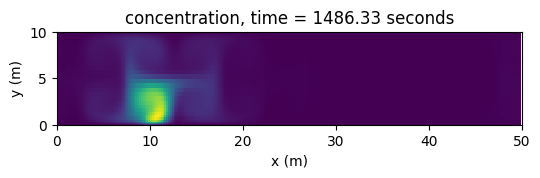

In [14]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf()
    concentration = plt.pcolor(X, Y, c_save[n,:,:].T)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlim(0, L)
    plt.ylim(0, w)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('concentration, time = {0:.2f} seconds'.format(t_save[n]))
    return (concentration,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

In [15]:
concentration = False
for time in range(len(t_save)):
  for xpos in range(0,Nx):
    if c_save[time, xpos, -1] >0:
      print (f"pollution first crosses river at time = {t_save[time]} s, distance = {x[xpos,0]}m")
      concentration = True
      break
  if concentration == True:
    break

pollution first crosses river at time = 1.953125 s, distance = 3.7109375m


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s


2025-11-11 19:50:30,896 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s


INFO:__main__:Starting main loop


2025-11-11 19:50:30,902 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=9.765625e-01, dt=9.765625e-01


2025-11-11 19:50:31,052 __main__ 0/1 INFO :: Iteration=1, Time=9.765625e-01, dt=9.765625e-01


INFO:__main__:Iteration=11, Time=1.074219e+01, dt=9.765625e-01


2025-11-11 19:50:31,113 __main__ 0/1 INFO :: Iteration=11, Time=1.074219e+01, dt=9.765625e-01


INFO:__main__:Iteration=21, Time=2.050781e+01, dt=9.765625e-01


2025-11-11 19:50:31,173 __main__ 0/1 INFO :: Iteration=21, Time=2.050781e+01, dt=9.765625e-01


INFO:__main__:Iteration=31, Time=3.027344e+01, dt=9.765625e-01


2025-11-11 19:50:31,236 __main__ 0/1 INFO :: Iteration=31, Time=3.027344e+01, dt=9.765625e-01


INFO:__main__:Iteration=41, Time=4.003906e+01, dt=9.765625e-01


2025-11-11 19:50:31,291 __main__ 0/1 INFO :: Iteration=41, Time=4.003906e+01, dt=9.765625e-01


INFO:__main__:Iteration=51, Time=4.980469e+01, dt=9.765625e-01


2025-11-11 19:50:31,347 __main__ 0/1 INFO :: Iteration=51, Time=4.980469e+01, dt=9.765625e-01


INFO:__main__:Iteration=61, Time=5.957031e+01, dt=9.765625e-01


2025-11-11 19:50:31,407 __main__ 0/1 INFO :: Iteration=61, Time=5.957031e+01, dt=9.765625e-01


INFO:__main__:Iteration=71, Time=6.933594e+01, dt=9.765625e-01


2025-11-11 19:50:31,475 __main__ 0/1 INFO :: Iteration=71, Time=6.933594e+01, dt=9.765625e-01


INFO:__main__:Iteration=81, Time=7.910156e+01, dt=9.765625e-01


2025-11-11 19:50:31,542 __main__ 0/1 INFO :: Iteration=81, Time=7.910156e+01, dt=9.765625e-01


INFO:__main__:Iteration=91, Time=8.886719e+01, dt=9.765625e-01


2025-11-11 19:50:31,605 __main__ 0/1 INFO :: Iteration=91, Time=8.886719e+01, dt=9.765625e-01


INFO:__main__:Iteration=101, Time=9.863281e+01, dt=9.765625e-01


2025-11-11 19:50:31,662 __main__ 0/1 INFO :: Iteration=101, Time=9.863281e+01, dt=9.765625e-01


INFO:__main__:Iteration=111, Time=1.083984e+02, dt=9.765625e-01


2025-11-11 19:50:31,719 __main__ 0/1 INFO :: Iteration=111, Time=1.083984e+02, dt=9.765625e-01


INFO:__main__:Iteration=121, Time=1.181641e+02, dt=9.765625e-01


2025-11-11 19:50:31,780 __main__ 0/1 INFO :: Iteration=121, Time=1.181641e+02, dt=9.765625e-01


INFO:__main__:Iteration=131, Time=1.279297e+02, dt=9.765625e-01


2025-11-11 19:50:31,836 __main__ 0/1 INFO :: Iteration=131, Time=1.279297e+02, dt=9.765625e-01


INFO:__main__:Iteration=141, Time=1.376953e+02, dt=9.765625e-01


2025-11-11 19:50:31,892 __main__ 0/1 INFO :: Iteration=141, Time=1.376953e+02, dt=9.765625e-01


INFO:__main__:Iteration=151, Time=1.474609e+02, dt=9.765625e-01


2025-11-11 19:50:31,949 __main__ 0/1 INFO :: Iteration=151, Time=1.474609e+02, dt=9.765625e-01


INFO:__main__:Iteration=161, Time=1.572266e+02, dt=9.765625e-01


2025-11-11 19:50:32,016 __main__ 0/1 INFO :: Iteration=161, Time=1.572266e+02, dt=9.765625e-01


INFO:__main__:Iteration=171, Time=1.669922e+02, dt=9.765625e-01


2025-11-11 19:50:32,071 __main__ 0/1 INFO :: Iteration=171, Time=1.669922e+02, dt=9.765625e-01


INFO:__main__:Iteration=181, Time=1.767578e+02, dt=9.765625e-01


2025-11-11 19:50:32,130 __main__ 0/1 INFO :: Iteration=181, Time=1.767578e+02, dt=9.765625e-01


INFO:__main__:Iteration=191, Time=1.865234e+02, dt=9.765625e-01


2025-11-11 19:50:32,188 __main__ 0/1 INFO :: Iteration=191, Time=1.865234e+02, dt=9.765625e-01


INFO:__main__:Iteration=201, Time=1.962891e+02, dt=9.765625e-01


2025-11-11 19:50:32,251 __main__ 0/1 INFO :: Iteration=201, Time=1.962891e+02, dt=9.765625e-01


INFO:__main__:Iteration=211, Time=2.060547e+02, dt=9.765625e-01


2025-11-11 19:50:32,328 __main__ 0/1 INFO :: Iteration=211, Time=2.060547e+02, dt=9.765625e-01


INFO:__main__:Iteration=221, Time=2.158203e+02, dt=9.765625e-01


2025-11-11 19:50:32,390 __main__ 0/1 INFO :: Iteration=221, Time=2.158203e+02, dt=9.765625e-01


INFO:__main__:Iteration=231, Time=2.255859e+02, dt=9.765625e-01


2025-11-11 19:50:32,446 __main__ 0/1 INFO :: Iteration=231, Time=2.255859e+02, dt=9.765625e-01


INFO:__main__:Iteration=241, Time=2.353516e+02, dt=9.765625e-01


2025-11-11 19:50:32,506 __main__ 0/1 INFO :: Iteration=241, Time=2.353516e+02, dt=9.765625e-01


INFO:__main__:Iteration=251, Time=2.451172e+02, dt=9.765625e-01


2025-11-11 19:50:32,559 __main__ 0/1 INFO :: Iteration=251, Time=2.451172e+02, dt=9.765625e-01


INFO:__main__:Iteration=261, Time=2.548828e+02, dt=9.765625e-01


2025-11-11 19:50:32,613 __main__ 0/1 INFO :: Iteration=261, Time=2.548828e+02, dt=9.765625e-01


INFO:__main__:Iteration=271, Time=2.646484e+02, dt=9.765625e-01


2025-11-11 19:50:32,666 __main__ 0/1 INFO :: Iteration=271, Time=2.646484e+02, dt=9.765625e-01


INFO:__main__:Iteration=281, Time=2.744141e+02, dt=9.765625e-01


2025-11-11 19:50:32,720 __main__ 0/1 INFO :: Iteration=281, Time=2.744141e+02, dt=9.765625e-01


INFO:__main__:Iteration=291, Time=2.841797e+02, dt=9.765625e-01


2025-11-11 19:50:32,771 __main__ 0/1 INFO :: Iteration=291, Time=2.841797e+02, dt=9.765625e-01


INFO:__main__:Iteration=301, Time=2.939453e+02, dt=9.765625e-01


2025-11-11 19:50:32,823 __main__ 0/1 INFO :: Iteration=301, Time=2.939453e+02, dt=9.765625e-01


INFO:__main__:Iteration=311, Time=3.037109e+02, dt=9.765625e-01


2025-11-11 19:50:32,877 __main__ 0/1 INFO :: Iteration=311, Time=3.037109e+02, dt=9.765625e-01


INFO:__main__:Iteration=321, Time=3.134766e+02, dt=9.765625e-01


2025-11-11 19:50:32,936 __main__ 0/1 INFO :: Iteration=321, Time=3.134766e+02, dt=9.765625e-01


INFO:__main__:Iteration=331, Time=3.232422e+02, dt=9.765625e-01


2025-11-11 19:50:32,991 __main__ 0/1 INFO :: Iteration=331, Time=3.232422e+02, dt=9.765625e-01


INFO:__main__:Iteration=341, Time=3.330078e+02, dt=9.765625e-01


2025-11-11 19:50:33,058 __main__ 0/1 INFO :: Iteration=341, Time=3.330078e+02, dt=9.765625e-01


INFO:__main__:Iteration=351, Time=3.427734e+02, dt=9.765625e-01


2025-11-11 19:50:33,112 __main__ 0/1 INFO :: Iteration=351, Time=3.427734e+02, dt=9.765625e-01


INFO:__main__:Iteration=361, Time=3.525391e+02, dt=9.765625e-01


2025-11-11 19:50:33,168 __main__ 0/1 INFO :: Iteration=361, Time=3.525391e+02, dt=9.765625e-01


INFO:__main__:Iteration=371, Time=3.623047e+02, dt=9.765625e-01


2025-11-11 19:50:33,226 __main__ 0/1 INFO :: Iteration=371, Time=3.623047e+02, dt=9.765625e-01


INFO:__main__:Iteration=381, Time=3.720703e+02, dt=9.765625e-01


2025-11-11 19:50:33,280 __main__ 0/1 INFO :: Iteration=381, Time=3.720703e+02, dt=9.765625e-01


INFO:__main__:Iteration=391, Time=3.818359e+02, dt=9.765625e-01


2025-11-11 19:50:33,336 __main__ 0/1 INFO :: Iteration=391, Time=3.818359e+02, dt=9.765625e-01


INFO:__main__:Iteration=401, Time=3.916016e+02, dt=9.765625e-01


2025-11-11 19:50:33,393 __main__ 0/1 INFO :: Iteration=401, Time=3.916016e+02, dt=9.765625e-01


INFO:__main__:Iteration=411, Time=4.013672e+02, dt=9.765625e-01


2025-11-11 19:50:33,447 __main__ 0/1 INFO :: Iteration=411, Time=4.013672e+02, dt=9.765625e-01


INFO:__main__:Iteration=421, Time=4.111328e+02, dt=9.765625e-01


2025-11-11 19:50:33,509 __main__ 0/1 INFO :: Iteration=421, Time=4.111328e+02, dt=9.765625e-01


INFO:__main__:Iteration=431, Time=4.208984e+02, dt=9.765625e-01


2025-11-11 19:50:33,567 __main__ 0/1 INFO :: Iteration=431, Time=4.208984e+02, dt=9.765625e-01


INFO:__main__:Iteration=441, Time=4.306641e+02, dt=9.765625e-01


2025-11-11 19:50:33,627 __main__ 0/1 INFO :: Iteration=441, Time=4.306641e+02, dt=9.765625e-01


INFO:__main__:Iteration=451, Time=4.404297e+02, dt=9.765625e-01


2025-11-11 19:50:33,685 __main__ 0/1 INFO :: Iteration=451, Time=4.404297e+02, dt=9.765625e-01


INFO:__main__:Iteration=461, Time=4.501953e+02, dt=9.765625e-01


2025-11-11 19:50:33,741 __main__ 0/1 INFO :: Iteration=461, Time=4.501953e+02, dt=9.765625e-01


INFO:__main__:Iteration=471, Time=4.599609e+02, dt=9.765625e-01


2025-11-11 19:50:33,799 __main__ 0/1 INFO :: Iteration=471, Time=4.599609e+02, dt=9.765625e-01


INFO:__main__:Iteration=481, Time=4.697266e+02, dt=9.765625e-01


2025-11-11 19:50:33,856 __main__ 0/1 INFO :: Iteration=481, Time=4.697266e+02, dt=9.765625e-01


INFO:__main__:Iteration=491, Time=4.794922e+02, dt=9.765625e-01


2025-11-11 19:50:33,913 __main__ 0/1 INFO :: Iteration=491, Time=4.794922e+02, dt=9.765625e-01


INFO:__main__:Iteration=501, Time=4.892578e+02, dt=9.765625e-01


2025-11-11 19:50:33,970 __main__ 0/1 INFO :: Iteration=501, Time=4.892578e+02, dt=9.765625e-01


INFO:__main__:Iteration=511, Time=4.990234e+02, dt=9.765625e-01


2025-11-11 19:50:34,025 __main__ 0/1 INFO :: Iteration=511, Time=4.990234e+02, dt=9.765625e-01


INFO:__main__:Iteration=521, Time=5.087891e+02, dt=9.765625e-01


2025-11-11 19:50:34,100 __main__ 0/1 INFO :: Iteration=521, Time=5.087891e+02, dt=9.765625e-01


INFO:__main__:Iteration=531, Time=5.185547e+02, dt=9.765625e-01


2025-11-11 19:50:34,156 __main__ 0/1 INFO :: Iteration=531, Time=5.185547e+02, dt=9.765625e-01


INFO:__main__:Iteration=541, Time=5.283203e+02, dt=9.765625e-01


2025-11-11 19:50:34,215 __main__ 0/1 INFO :: Iteration=541, Time=5.283203e+02, dt=9.765625e-01


INFO:__main__:Iteration=551, Time=5.380859e+02, dt=9.765625e-01


2025-11-11 19:50:34,274 __main__ 0/1 INFO :: Iteration=551, Time=5.380859e+02, dt=9.765625e-01


INFO:__main__:Iteration=561, Time=5.478516e+02, dt=9.765625e-01


2025-11-11 19:50:34,334 __main__ 0/1 INFO :: Iteration=561, Time=5.478516e+02, dt=9.765625e-01


INFO:__main__:Iteration=571, Time=5.576172e+02, dt=9.765625e-01


2025-11-11 19:50:34,395 __main__ 0/1 INFO :: Iteration=571, Time=5.576172e+02, dt=9.765625e-01


INFO:__main__:Iteration=581, Time=5.673828e+02, dt=9.765625e-01


2025-11-11 19:50:34,454 __main__ 0/1 INFO :: Iteration=581, Time=5.673828e+02, dt=9.765625e-01


INFO:__main__:Iteration=591, Time=5.771484e+02, dt=9.765625e-01


2025-11-11 19:50:34,514 __main__ 0/1 INFO :: Iteration=591, Time=5.771484e+02, dt=9.765625e-01


INFO:__main__:Iteration=601, Time=5.869141e+02, dt=9.765625e-01


2025-11-11 19:50:34,570 __main__ 0/1 INFO :: Iteration=601, Time=5.869141e+02, dt=9.765625e-01


INFO:__main__:Iteration=611, Time=5.966797e+02, dt=9.765625e-01


2025-11-11 19:50:34,628 __main__ 0/1 INFO :: Iteration=611, Time=5.966797e+02, dt=9.765625e-01


INFO:__main__:Iteration=621, Time=6.064453e+02, dt=9.765625e-01


2025-11-11 19:50:34,687 __main__ 0/1 INFO :: Iteration=621, Time=6.064453e+02, dt=9.765625e-01


INFO:__main__:Iteration=631, Time=6.162109e+02, dt=9.765625e-01


2025-11-11 19:50:34,742 __main__ 0/1 INFO :: Iteration=631, Time=6.162109e+02, dt=9.765625e-01


INFO:__main__:Iteration=641, Time=6.259766e+02, dt=9.765625e-01


2025-11-11 19:50:34,799 __main__ 0/1 INFO :: Iteration=641, Time=6.259766e+02, dt=9.765625e-01


INFO:__main__:Iteration=651, Time=6.357422e+02, dt=9.765625e-01


2025-11-11 19:50:34,857 __main__ 0/1 INFO :: Iteration=651, Time=6.357422e+02, dt=9.765625e-01


INFO:__main__:Iteration=661, Time=6.455078e+02, dt=9.765625e-01


2025-11-11 19:50:34,915 __main__ 0/1 INFO :: Iteration=661, Time=6.455078e+02, dt=9.765625e-01


INFO:__main__:Iteration=671, Time=6.552734e+02, dt=9.765625e-01


2025-11-11 19:50:34,973 __main__ 0/1 INFO :: Iteration=671, Time=6.552734e+02, dt=9.765625e-01


INFO:__main__:Iteration=681, Time=6.650391e+02, dt=9.765625e-01


2025-11-11 19:50:35,030 __main__ 0/1 INFO :: Iteration=681, Time=6.650391e+02, dt=9.765625e-01


INFO:__main__:Iteration=691, Time=6.748047e+02, dt=9.765625e-01


2025-11-11 19:50:35,093 __main__ 0/1 INFO :: Iteration=691, Time=6.748047e+02, dt=9.765625e-01


INFO:__main__:Iteration=701, Time=6.845703e+02, dt=9.765625e-01


2025-11-11 19:50:35,158 __main__ 0/1 INFO :: Iteration=701, Time=6.845703e+02, dt=9.765625e-01


INFO:__main__:Iteration=711, Time=6.943359e+02, dt=9.765625e-01


2025-11-11 19:50:35,224 __main__ 0/1 INFO :: Iteration=711, Time=6.943359e+02, dt=9.765625e-01


INFO:__main__:Iteration=721, Time=7.041016e+02, dt=9.765625e-01


2025-11-11 19:50:35,282 __main__ 0/1 INFO :: Iteration=721, Time=7.041016e+02, dt=9.765625e-01


INFO:__main__:Iteration=731, Time=7.138672e+02, dt=9.765625e-01


2025-11-11 19:50:35,341 __main__ 0/1 INFO :: Iteration=731, Time=7.138672e+02, dt=9.765625e-01


INFO:__main__:Iteration=741, Time=7.236328e+02, dt=9.765625e-01


2025-11-11 19:50:35,399 __main__ 0/1 INFO :: Iteration=741, Time=7.236328e+02, dt=9.765625e-01


INFO:__main__:Iteration=751, Time=7.333984e+02, dt=9.765625e-01


2025-11-11 19:50:35,458 __main__ 0/1 INFO :: Iteration=751, Time=7.333984e+02, dt=9.765625e-01


INFO:__main__:Iteration=761, Time=7.431641e+02, dt=9.765625e-01


2025-11-11 19:50:35,518 __main__ 0/1 INFO :: Iteration=761, Time=7.431641e+02, dt=9.765625e-01


INFO:__main__:Iteration=771, Time=7.529297e+02, dt=9.765625e-01


2025-11-11 19:50:35,575 __main__ 0/1 INFO :: Iteration=771, Time=7.529297e+02, dt=9.765625e-01


INFO:__main__:Iteration=781, Time=7.626953e+02, dt=9.765625e-01


2025-11-11 19:50:35,634 __main__ 0/1 INFO :: Iteration=781, Time=7.626953e+02, dt=9.765625e-01


INFO:__main__:Iteration=791, Time=7.724609e+02, dt=9.765625e-01


2025-11-11 19:50:35,692 __main__ 0/1 INFO :: Iteration=791, Time=7.724609e+02, dt=9.765625e-01


INFO:__main__:Iteration=801, Time=7.822266e+02, dt=9.765625e-01


2025-11-11 19:50:35,748 __main__ 0/1 INFO :: Iteration=801, Time=7.822266e+02, dt=9.765625e-01


INFO:__main__:Iteration=811, Time=7.919922e+02, dt=9.765625e-01


2025-11-11 19:50:35,805 __main__ 0/1 INFO :: Iteration=811, Time=7.919922e+02, dt=9.765625e-01


INFO:__main__:Iteration=821, Time=8.017578e+02, dt=9.765625e-01


2025-11-11 19:50:35,864 __main__ 0/1 INFO :: Iteration=821, Time=8.017578e+02, dt=9.765625e-01


INFO:__main__:Iteration=831, Time=8.115234e+02, dt=9.765625e-01


2025-11-11 19:50:35,921 __main__ 0/1 INFO :: Iteration=831, Time=8.115234e+02, dt=9.765625e-01


INFO:__main__:Iteration=841, Time=8.212891e+02, dt=9.765625e-01


2025-11-11 19:50:35,977 __main__ 0/1 INFO :: Iteration=841, Time=8.212891e+02, dt=9.765625e-01


INFO:__main__:Iteration=851, Time=8.310547e+02, dt=9.765625e-01


2025-11-11 19:50:36,033 __main__ 0/1 INFO :: Iteration=851, Time=8.310547e+02, dt=9.765625e-01


INFO:__main__:Iteration=861, Time=8.408203e+02, dt=9.765625e-01


2025-11-11 19:50:36,088 __main__ 0/1 INFO :: Iteration=861, Time=8.408203e+02, dt=9.765625e-01


INFO:__main__:Iteration=871, Time=8.505859e+02, dt=9.765625e-01


2025-11-11 19:50:36,158 __main__ 0/1 INFO :: Iteration=871, Time=8.505859e+02, dt=9.765625e-01


INFO:__main__:Iteration=881, Time=8.603516e+02, dt=9.765625e-01


2025-11-11 19:50:36,217 __main__ 0/1 INFO :: Iteration=881, Time=8.603516e+02, dt=9.765625e-01


INFO:__main__:Iteration=891, Time=8.701172e+02, dt=9.765625e-01


2025-11-11 19:50:36,275 __main__ 0/1 INFO :: Iteration=891, Time=8.701172e+02, dt=9.765625e-01


INFO:__main__:Iteration=901, Time=8.798828e+02, dt=9.765625e-01


2025-11-11 19:50:36,333 __main__ 0/1 INFO :: Iteration=901, Time=8.798828e+02, dt=9.765625e-01


INFO:__main__:Iteration=911, Time=8.896484e+02, dt=9.765625e-01


2025-11-11 19:50:36,390 __main__ 0/1 INFO :: Iteration=911, Time=8.896484e+02, dt=9.765625e-01


INFO:__main__:Iteration=921, Time=8.994141e+02, dt=9.765625e-01


2025-11-11 19:50:36,457 __main__ 0/1 INFO :: Iteration=921, Time=8.994141e+02, dt=9.765625e-01


INFO:__main__:Iteration=931, Time=9.091797e+02, dt=9.765625e-01


2025-11-11 19:50:36,520 __main__ 0/1 INFO :: Iteration=931, Time=9.091797e+02, dt=9.765625e-01


INFO:__main__:Iteration=941, Time=9.189453e+02, dt=9.765625e-01


2025-11-11 19:50:36,582 __main__ 0/1 INFO :: Iteration=941, Time=9.189453e+02, dt=9.765625e-01


INFO:__main__:Iteration=951, Time=9.287109e+02, dt=9.765625e-01


2025-11-11 19:50:36,641 __main__ 0/1 INFO :: Iteration=951, Time=9.287109e+02, dt=9.765625e-01


INFO:__main__:Iteration=961, Time=9.384766e+02, dt=9.765625e-01


2025-11-11 19:50:36,702 __main__ 0/1 INFO :: Iteration=961, Time=9.384766e+02, dt=9.765625e-01


INFO:__main__:Iteration=971, Time=9.482422e+02, dt=9.765625e-01


2025-11-11 19:50:36,768 __main__ 0/1 INFO :: Iteration=971, Time=9.482422e+02, dt=9.765625e-01


INFO:__main__:Iteration=981, Time=9.580078e+02, dt=9.765625e-01


2025-11-11 19:50:36,830 __main__ 0/1 INFO :: Iteration=981, Time=9.580078e+02, dt=9.765625e-01


INFO:__main__:Iteration=991, Time=9.677734e+02, dt=9.765625e-01


2025-11-11 19:50:36,894 __main__ 0/1 INFO :: Iteration=991, Time=9.677734e+02, dt=9.765625e-01


INFO:__main__:Iteration=1001, Time=9.775391e+02, dt=9.765625e-01


2025-11-11 19:50:36,959 __main__ 0/1 INFO :: Iteration=1001, Time=9.775391e+02, dt=9.765625e-01


INFO:__main__:Iteration=1011, Time=9.873047e+02, dt=9.765625e-01


2025-11-11 19:50:37,019 __main__ 0/1 INFO :: Iteration=1011, Time=9.873047e+02, dt=9.765625e-01


INFO:__main__:Iteration=1021, Time=9.970703e+02, dt=9.765625e-01


2025-11-11 19:50:37,081 __main__ 0/1 INFO :: Iteration=1021, Time=9.970703e+02, dt=9.765625e-01


INFO:__main__:Iteration=1031, Time=1.006836e+03, dt=9.765625e-01


2025-11-11 19:50:37,188 __main__ 0/1 INFO :: Iteration=1031, Time=1.006836e+03, dt=9.765625e-01


INFO:__main__:Iteration=1041, Time=1.016602e+03, dt=9.765625e-01


2025-11-11 19:50:37,283 __main__ 0/1 INFO :: Iteration=1041, Time=1.016602e+03, dt=9.765625e-01


INFO:__main__:Iteration=1051, Time=1.026367e+03, dt=9.765625e-01


2025-11-11 19:50:37,361 __main__ 0/1 INFO :: Iteration=1051, Time=1.026367e+03, dt=9.765625e-01


INFO:__main__:Iteration=1061, Time=1.036133e+03, dt=9.765625e-01


2025-11-11 19:50:37,435 __main__ 0/1 INFO :: Iteration=1061, Time=1.036133e+03, dt=9.765625e-01


INFO:__main__:Iteration=1071, Time=1.045898e+03, dt=9.765625e-01


2025-11-11 19:50:37,520 __main__ 0/1 INFO :: Iteration=1071, Time=1.045898e+03, dt=9.765625e-01


INFO:__main__:Iteration=1081, Time=1.055664e+03, dt=9.765625e-01


2025-11-11 19:50:37,599 __main__ 0/1 INFO :: Iteration=1081, Time=1.055664e+03, dt=9.765625e-01


INFO:__main__:Iteration=1091, Time=1.065430e+03, dt=9.765625e-01


2025-11-11 19:50:37,680 __main__ 0/1 INFO :: Iteration=1091, Time=1.065430e+03, dt=9.765625e-01


INFO:__main__:Iteration=1101, Time=1.075195e+03, dt=9.765625e-01


2025-11-11 19:50:37,762 __main__ 0/1 INFO :: Iteration=1101, Time=1.075195e+03, dt=9.765625e-01


INFO:__main__:Iteration=1111, Time=1.084961e+03, dt=9.765625e-01


2025-11-11 19:50:37,841 __main__ 0/1 INFO :: Iteration=1111, Time=1.084961e+03, dt=9.765625e-01


INFO:__main__:Iteration=1121, Time=1.094727e+03, dt=9.765625e-01


2025-11-11 19:50:37,922 __main__ 0/1 INFO :: Iteration=1121, Time=1.094727e+03, dt=9.765625e-01


INFO:__main__:Iteration=1131, Time=1.104492e+03, dt=9.765625e-01


2025-11-11 19:50:38,001 __main__ 0/1 INFO :: Iteration=1131, Time=1.104492e+03, dt=9.765625e-01


INFO:__main__:Iteration=1141, Time=1.114258e+03, dt=9.765625e-01


2025-11-11 19:50:38,082 __main__ 0/1 INFO :: Iteration=1141, Time=1.114258e+03, dt=9.765625e-01


INFO:__main__:Iteration=1151, Time=1.124023e+03, dt=9.765625e-01


2025-11-11 19:50:38,172 __main__ 0/1 INFO :: Iteration=1151, Time=1.124023e+03, dt=9.765625e-01


INFO:__main__:Iteration=1161, Time=1.133789e+03, dt=9.765625e-01


2025-11-11 19:50:38,256 __main__ 0/1 INFO :: Iteration=1161, Time=1.133789e+03, dt=9.765625e-01


INFO:__main__:Iteration=1171, Time=1.143555e+03, dt=9.765625e-01


2025-11-11 19:50:38,352 __main__ 0/1 INFO :: Iteration=1171, Time=1.143555e+03, dt=9.765625e-01


INFO:__main__:Iteration=1181, Time=1.153320e+03, dt=9.765625e-01


2025-11-11 19:50:38,436 __main__ 0/1 INFO :: Iteration=1181, Time=1.153320e+03, dt=9.765625e-01


INFO:__main__:Iteration=1191, Time=1.163086e+03, dt=9.765625e-01


2025-11-11 19:50:38,521 __main__ 0/1 INFO :: Iteration=1191, Time=1.163086e+03, dt=9.765625e-01


INFO:__main__:Iteration=1201, Time=1.172852e+03, dt=9.765625e-01


2025-11-11 19:50:38,598 __main__ 0/1 INFO :: Iteration=1201, Time=1.172852e+03, dt=9.765625e-01


INFO:__main__:Iteration=1211, Time=1.182617e+03, dt=9.765625e-01


2025-11-11 19:50:38,680 __main__ 0/1 INFO :: Iteration=1211, Time=1.182617e+03, dt=9.765625e-01


INFO:__main__:Iteration=1221, Time=1.192383e+03, dt=9.765625e-01


2025-11-11 19:50:38,759 __main__ 0/1 INFO :: Iteration=1221, Time=1.192383e+03, dt=9.765625e-01


INFO:__main__:Iteration=1231, Time=1.202148e+03, dt=9.765625e-01


2025-11-11 19:50:38,836 __main__ 0/1 INFO :: Iteration=1231, Time=1.202148e+03, dt=9.765625e-01


INFO:__main__:Iteration=1241, Time=1.211914e+03, dt=9.765625e-01


2025-11-11 19:50:38,917 __main__ 0/1 INFO :: Iteration=1241, Time=1.211914e+03, dt=9.765625e-01


INFO:__main__:Iteration=1251, Time=1.221680e+03, dt=9.765625e-01


2025-11-11 19:50:39,003 __main__ 0/1 INFO :: Iteration=1251, Time=1.221680e+03, dt=9.765625e-01


INFO:__main__:Iteration=1261, Time=1.231445e+03, dt=9.765625e-01


2025-11-11 19:50:39,095 __main__ 0/1 INFO :: Iteration=1261, Time=1.231445e+03, dt=9.765625e-01


INFO:__main__:Iteration=1271, Time=1.241211e+03, dt=9.765625e-01


2025-11-11 19:50:39,177 __main__ 0/1 INFO :: Iteration=1271, Time=1.241211e+03, dt=9.765625e-01


INFO:__main__:Iteration=1281, Time=1.250977e+03, dt=9.765625e-01


2025-11-11 19:50:39,259 __main__ 0/1 INFO :: Iteration=1281, Time=1.250977e+03, dt=9.765625e-01


INFO:__main__:Iteration=1291, Time=1.260742e+03, dt=9.765625e-01


2025-11-11 19:50:39,343 __main__ 0/1 INFO :: Iteration=1291, Time=1.260742e+03, dt=9.765625e-01


INFO:__main__:Iteration=1301, Time=1.270508e+03, dt=9.765625e-01


2025-11-11 19:50:39,438 __main__ 0/1 INFO :: Iteration=1301, Time=1.270508e+03, dt=9.765625e-01


INFO:__main__:Iteration=1311, Time=1.280273e+03, dt=9.765625e-01


2025-11-11 19:50:39,525 __main__ 0/1 INFO :: Iteration=1311, Time=1.280273e+03, dt=9.765625e-01


INFO:__main__:Iteration=1321, Time=1.290039e+03, dt=9.765625e-01


2025-11-11 19:50:39,612 __main__ 0/1 INFO :: Iteration=1321, Time=1.290039e+03, dt=9.765625e-01


INFO:__main__:Iteration=1331, Time=1.299805e+03, dt=9.765625e-01


2025-11-11 19:50:39,695 __main__ 0/1 INFO :: Iteration=1331, Time=1.299805e+03, dt=9.765625e-01


INFO:__main__:Iteration=1341, Time=1.309570e+03, dt=9.765625e-01


2025-11-11 19:50:39,775 __main__ 0/1 INFO :: Iteration=1341, Time=1.309570e+03, dt=9.765625e-01


INFO:__main__:Iteration=1351, Time=1.319336e+03, dt=9.765625e-01


2025-11-11 19:50:39,859 __main__ 0/1 INFO :: Iteration=1351, Time=1.319336e+03, dt=9.765625e-01


INFO:__main__:Iteration=1361, Time=1.329102e+03, dt=9.765625e-01


2025-11-11 19:50:39,914 __main__ 0/1 INFO :: Iteration=1361, Time=1.329102e+03, dt=9.765625e-01


INFO:__main__:Iteration=1371, Time=1.338867e+03, dt=9.765625e-01


2025-11-11 19:50:39,972 __main__ 0/1 INFO :: Iteration=1371, Time=1.338867e+03, dt=9.765625e-01


INFO:__main__:Iteration=1381, Time=1.348633e+03, dt=9.765625e-01


2025-11-11 19:50:40,028 __main__ 0/1 INFO :: Iteration=1381, Time=1.348633e+03, dt=9.765625e-01


INFO:__main__:Iteration=1391, Time=1.358398e+03, dt=9.765625e-01


2025-11-11 19:50:40,085 __main__ 0/1 INFO :: Iteration=1391, Time=1.358398e+03, dt=9.765625e-01


INFO:__main__:Iteration=1401, Time=1.368164e+03, dt=9.765625e-01


2025-11-11 19:50:40,144 __main__ 0/1 INFO :: Iteration=1401, Time=1.368164e+03, dt=9.765625e-01


INFO:__main__:Iteration=1411, Time=1.377930e+03, dt=9.765625e-01


2025-11-11 19:50:40,198 __main__ 0/1 INFO :: Iteration=1411, Time=1.377930e+03, dt=9.765625e-01


INFO:__main__:Iteration=1421, Time=1.387695e+03, dt=9.765625e-01


2025-11-11 19:50:40,251 __main__ 0/1 INFO :: Iteration=1421, Time=1.387695e+03, dt=9.765625e-01


INFO:__main__:Iteration=1431, Time=1.397461e+03, dt=9.765625e-01


2025-11-11 19:50:40,306 __main__ 0/1 INFO :: Iteration=1431, Time=1.397461e+03, dt=9.765625e-01


INFO:__main__:Iteration=1441, Time=1.407227e+03, dt=9.765625e-01


2025-11-11 19:50:40,363 __main__ 0/1 INFO :: Iteration=1441, Time=1.407227e+03, dt=9.765625e-01


INFO:__main__:Iteration=1451, Time=1.416992e+03, dt=9.765625e-01


2025-11-11 19:50:40,428 __main__ 0/1 INFO :: Iteration=1451, Time=1.416992e+03, dt=9.765625e-01


INFO:__main__:Iteration=1461, Time=1.426758e+03, dt=9.765625e-01


2025-11-11 19:50:40,488 __main__ 0/1 INFO :: Iteration=1461, Time=1.426758e+03, dt=9.765625e-01


INFO:__main__:Iteration=1471, Time=1.436523e+03, dt=9.765625e-01


2025-11-11 19:50:40,548 __main__ 0/1 INFO :: Iteration=1471, Time=1.436523e+03, dt=9.765625e-01


INFO:__main__:Iteration=1481, Time=1.446289e+03, dt=9.765625e-01


2025-11-11 19:50:40,610 __main__ 0/1 INFO :: Iteration=1481, Time=1.446289e+03, dt=9.765625e-01


INFO:__main__:Iteration=1491, Time=1.456055e+03, dt=9.765625e-01


2025-11-11 19:50:40,671 __main__ 0/1 INFO :: Iteration=1491, Time=1.456055e+03, dt=9.765625e-01


INFO:__main__:Iteration=1501, Time=1.465820e+03, dt=9.765625e-01


2025-11-11 19:50:40,729 __main__ 0/1 INFO :: Iteration=1501, Time=1.465820e+03, dt=9.765625e-01


INFO:__main__:Iteration=1511, Time=1.475586e+03, dt=9.765625e-01


2025-11-11 19:50:40,785 __main__ 0/1 INFO :: Iteration=1511, Time=1.475586e+03, dt=9.765625e-01


INFO:__main__:Iteration=1521, Time=1.485352e+03, dt=9.765625e-01


2025-11-11 19:50:40,839 __main__ 0/1 INFO :: Iteration=1521, Time=1.485352e+03, dt=9.765625e-01


INFO:__main__:Iteration=1531, Time=1.495117e+03, dt=9.765625e-01


2025-11-11 19:50:40,895 __main__ 0/1 INFO :: Iteration=1531, Time=1.495117e+03, dt=9.765625e-01


INFO:solvers:Simulation stop time reached.


2025-11-11 19:50:40,930 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 1536


2025-11-11 19:50:40,932 solvers 0/1 INFO :: Final iteration: 1536


INFO:solvers:Final sim time: 1500.0


2025-11-11 19:50:40,935 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.5303 sec


2025-11-11 19:50:40,938 solvers 0/1 INFO :: Setup time (init - iter 0): 0.5303 sec


INFO:solvers:Warmup time (iter 0-10): 0.2036 sec


2025-11-11 19:50:40,942 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.2036 sec


INFO:solvers:Run time (iter 10-end): 9.825 sec


2025-11-11 19:50:40,944 solvers 0/1 INFO :: Run time (iter 10-end): 9.825 sec


INFO:solvers:CPU time (iter 10-end): 0.002729 cpu-hr


2025-11-11 19:50:40,946 solvers 0/1 INFO :: CPU time (iter 10-end): 0.002729 cpu-hr


INFO:solvers:Speed: 2.693e+06 mode-stages/cpu-sec


2025-11-11 19:50:40,950 solvers 0/1 INFO :: Speed: 2.693e+06 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-11 19:50:41,057 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpkierer87/temp.m4v


2025-11-11 19:50:41,058 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpkierer87/temp.m4v


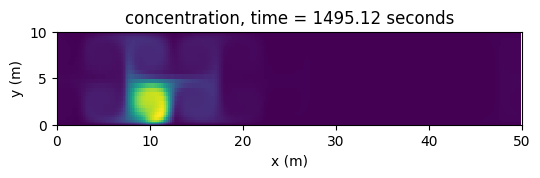

In [16]:
# U=0.2, k=pi/5

# Set parameters
U0 = 0.2 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale
k=np.pi*0.2 #NEW gives 1 wavelengths in width 10 choose np.pi for 5 wavelengths (gave negative concentration)

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

#def u(x,y,k):
  #return U0*np.cos(k*x)*np.cos(k*y)
#def v(x,y,k):
  #return U0*np.sin(k*x)*np.sin(k*y)

# Fields CHANGED
c = dist.Field(name='c', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field CHANGED
#u['g'] = u(x,y,k)
#v['g'] = v(x,y,k)
u['g'] = U0*np.cos(k*x)*np.cos(k*y)
v['g'] = U0*np.sin(k*x)*np.sin(k*y)

# Substitutions CHANGED
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem CHANGED
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) + v*dy(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)


fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf()
    concentration = plt.pcolor(X, Y, c_save[n,:,:].T)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlim(0, L)
    plt.ylim(0, w)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('concentration, time = {0:.2f} seconds'.format(t_save[n]))
    return (concentration,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())


In [17]:
concentration = False
for time in range(len(t_save)):
  for xpos in range(0,Nx):
    if c_save[time, xpos, -1] >0:
      print (f"pollution first crosses river at time = {t_save[time]} s, distance = {x[xpos,0]}m")
      concentration = True
      break
  if concentration == True:
    break

pollution first crosses river at time = 0.9765625 s, distance = 0.0m


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s


2025-11-11 19:51:12,384 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s


INFO:__main__:Starting main loop


2025-11-11 19:51:12,391 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=6.510417e-01, dt=6.510417e-01


2025-11-11 19:51:12,526 __main__ 0/1 INFO :: Iteration=1, Time=6.510417e-01, dt=6.510417e-01


INFO:__main__:Iteration=11, Time=7.161458e+00, dt=6.510417e-01


2025-11-11 19:51:12,582 __main__ 0/1 INFO :: Iteration=11, Time=7.161458e+00, dt=6.510417e-01


INFO:__main__:Iteration=21, Time=1.367187e+01, dt=6.510417e-01


2025-11-11 19:51:12,638 __main__ 0/1 INFO :: Iteration=21, Time=1.367187e+01, dt=6.510417e-01


INFO:__main__:Iteration=31, Time=2.018229e+01, dt=6.510417e-01


2025-11-11 19:51:12,697 __main__ 0/1 INFO :: Iteration=31, Time=2.018229e+01, dt=6.510417e-01


INFO:__main__:Iteration=41, Time=2.669271e+01, dt=6.510417e-01


2025-11-11 19:51:12,762 __main__ 0/1 INFO :: Iteration=41, Time=2.669271e+01, dt=6.510417e-01


INFO:__main__:Iteration=51, Time=3.320313e+01, dt=6.510417e-01


2025-11-11 19:51:12,826 __main__ 0/1 INFO :: Iteration=51, Time=3.320313e+01, dt=6.510417e-01


INFO:__main__:Iteration=61, Time=3.971354e+01, dt=6.510417e-01


2025-11-11 19:51:12,885 __main__ 0/1 INFO :: Iteration=61, Time=3.971354e+01, dt=6.510417e-01


INFO:__main__:Iteration=71, Time=4.622396e+01, dt=6.510417e-01


2025-11-11 19:51:12,944 __main__ 0/1 INFO :: Iteration=71, Time=4.622396e+01, dt=6.510417e-01


INFO:__main__:Iteration=81, Time=5.273437e+01, dt=6.510417e-01


2025-11-11 19:51:13,001 __main__ 0/1 INFO :: Iteration=81, Time=5.273437e+01, dt=6.510417e-01


INFO:__main__:Iteration=91, Time=5.924479e+01, dt=6.510417e-01


2025-11-11 19:51:13,058 __main__ 0/1 INFO :: Iteration=91, Time=5.924479e+01, dt=6.510417e-01


INFO:__main__:Iteration=101, Time=6.575521e+01, dt=6.510417e-01


2025-11-11 19:51:13,116 __main__ 0/1 INFO :: Iteration=101, Time=6.575521e+01, dt=6.510417e-01


INFO:__main__:Iteration=111, Time=7.226562e+01, dt=6.510417e-01


2025-11-11 19:51:13,175 __main__ 0/1 INFO :: Iteration=111, Time=7.226562e+01, dt=6.510417e-01


INFO:__main__:Iteration=121, Time=7.877604e+01, dt=6.510417e-01


2025-11-11 19:51:13,232 __main__ 0/1 INFO :: Iteration=121, Time=7.877604e+01, dt=6.510417e-01


INFO:__main__:Iteration=131, Time=8.528646e+01, dt=6.510417e-01


2025-11-11 19:51:13,291 __main__ 0/1 INFO :: Iteration=131, Time=8.528646e+01, dt=6.510417e-01


INFO:__main__:Iteration=141, Time=9.179688e+01, dt=6.510417e-01


2025-11-11 19:51:13,347 __main__ 0/1 INFO :: Iteration=141, Time=9.179688e+01, dt=6.510417e-01


INFO:__main__:Iteration=151, Time=9.830729e+01, dt=6.510417e-01


2025-11-11 19:51:13,403 __main__ 0/1 INFO :: Iteration=151, Time=9.830729e+01, dt=6.510417e-01


INFO:__main__:Iteration=161, Time=1.048177e+02, dt=6.510417e-01


2025-11-11 19:51:13,460 __main__ 0/1 INFO :: Iteration=161, Time=1.048177e+02, dt=6.510417e-01


INFO:__main__:Iteration=171, Time=1.113281e+02, dt=6.510417e-01


2025-11-11 19:51:13,517 __main__ 0/1 INFO :: Iteration=171, Time=1.113281e+02, dt=6.510417e-01


INFO:__main__:Iteration=181, Time=1.178385e+02, dt=6.510417e-01


2025-11-11 19:51:13,569 __main__ 0/1 INFO :: Iteration=181, Time=1.178385e+02, dt=6.510417e-01


INFO:__main__:Iteration=191, Time=1.243490e+02, dt=6.510417e-01


2025-11-11 19:51:13,627 __main__ 0/1 INFO :: Iteration=191, Time=1.243490e+02, dt=6.510417e-01


INFO:__main__:Iteration=201, Time=1.308594e+02, dt=6.510417e-01


2025-11-11 19:51:13,682 __main__ 0/1 INFO :: Iteration=201, Time=1.308594e+02, dt=6.510417e-01


INFO:__main__:Iteration=211, Time=1.373698e+02, dt=6.510417e-01


2025-11-11 19:51:13,736 __main__ 0/1 INFO :: Iteration=211, Time=1.373698e+02, dt=6.510417e-01


INFO:__main__:Iteration=221, Time=1.438802e+02, dt=6.510417e-01


2025-11-11 19:51:13,797 __main__ 0/1 INFO :: Iteration=221, Time=1.438802e+02, dt=6.510417e-01


INFO:__main__:Iteration=231, Time=1.503906e+02, dt=6.510417e-01


2025-11-11 19:51:13,861 __main__ 0/1 INFO :: Iteration=231, Time=1.503906e+02, dt=6.510417e-01


INFO:__main__:Iteration=241, Time=1.569010e+02, dt=6.510417e-01


2025-11-11 19:51:13,917 __main__ 0/1 INFO :: Iteration=241, Time=1.569010e+02, dt=6.510417e-01


INFO:__main__:Iteration=251, Time=1.634115e+02, dt=6.510417e-01


2025-11-11 19:51:13,971 __main__ 0/1 INFO :: Iteration=251, Time=1.634115e+02, dt=6.510417e-01


INFO:__main__:Iteration=261, Time=1.699219e+02, dt=6.510417e-01


2025-11-11 19:51:14,028 __main__ 0/1 INFO :: Iteration=261, Time=1.699219e+02, dt=6.510417e-01


INFO:__main__:Iteration=271, Time=1.764323e+02, dt=6.510417e-01


2025-11-11 19:51:14,084 __main__ 0/1 INFO :: Iteration=271, Time=1.764323e+02, dt=6.510417e-01


INFO:__main__:Iteration=281, Time=1.829427e+02, dt=6.510417e-01


2025-11-11 19:51:14,143 __main__ 0/1 INFO :: Iteration=281, Time=1.829427e+02, dt=6.510417e-01


INFO:__main__:Iteration=291, Time=1.894531e+02, dt=6.510417e-01


2025-11-11 19:51:14,196 __main__ 0/1 INFO :: Iteration=291, Time=1.894531e+02, dt=6.510417e-01


INFO:__main__:Iteration=301, Time=1.959635e+02, dt=6.510417e-01


2025-11-11 19:51:14,253 __main__ 0/1 INFO :: Iteration=301, Time=1.959635e+02, dt=6.510417e-01


INFO:__main__:Iteration=311, Time=2.024740e+02, dt=6.510417e-01


2025-11-11 19:51:14,310 __main__ 0/1 INFO :: Iteration=311, Time=2.024740e+02, dt=6.510417e-01


INFO:__main__:Iteration=321, Time=2.089844e+02, dt=6.510417e-01


2025-11-11 19:51:14,367 __main__ 0/1 INFO :: Iteration=321, Time=2.089844e+02, dt=6.510417e-01


INFO:__main__:Iteration=331, Time=2.154948e+02, dt=6.510417e-01


2025-11-11 19:51:14,422 __main__ 0/1 INFO :: Iteration=331, Time=2.154948e+02, dt=6.510417e-01


INFO:__main__:Iteration=341, Time=2.220052e+02, dt=6.510417e-01


2025-11-11 19:51:14,479 __main__ 0/1 INFO :: Iteration=341, Time=2.220052e+02, dt=6.510417e-01


INFO:__main__:Iteration=351, Time=2.285156e+02, dt=6.510417e-01


2025-11-11 19:51:14,537 __main__ 0/1 INFO :: Iteration=351, Time=2.285156e+02, dt=6.510417e-01


INFO:__main__:Iteration=361, Time=2.350260e+02, dt=6.510417e-01


2025-11-11 19:51:14,592 __main__ 0/1 INFO :: Iteration=361, Time=2.350260e+02, dt=6.510417e-01


INFO:__main__:Iteration=371, Time=2.415365e+02, dt=6.510417e-01


2025-11-11 19:51:14,652 __main__ 0/1 INFO :: Iteration=371, Time=2.415365e+02, dt=6.510417e-01


INFO:__main__:Iteration=381, Time=2.480469e+02, dt=6.510417e-01


2025-11-11 19:51:14,716 __main__ 0/1 INFO :: Iteration=381, Time=2.480469e+02, dt=6.510417e-01


INFO:__main__:Iteration=391, Time=2.545573e+02, dt=6.510417e-01


2025-11-11 19:51:14,778 __main__ 0/1 INFO :: Iteration=391, Time=2.545573e+02, dt=6.510417e-01


INFO:__main__:Iteration=401, Time=2.610677e+02, dt=6.510417e-01


2025-11-11 19:51:14,851 __main__ 0/1 INFO :: Iteration=401, Time=2.610677e+02, dt=6.510417e-01


INFO:__main__:Iteration=411, Time=2.675781e+02, dt=6.510417e-01


2025-11-11 19:51:14,915 __main__ 0/1 INFO :: Iteration=411, Time=2.675781e+02, dt=6.510417e-01


INFO:__main__:Iteration=421, Time=2.740885e+02, dt=6.510417e-01


2025-11-11 19:51:14,977 __main__ 0/1 INFO :: Iteration=421, Time=2.740885e+02, dt=6.510417e-01


INFO:__main__:Iteration=431, Time=2.805990e+02, dt=6.510417e-01


2025-11-11 19:51:15,038 __main__ 0/1 INFO :: Iteration=431, Time=2.805990e+02, dt=6.510417e-01


INFO:__main__:Iteration=441, Time=2.871094e+02, dt=6.510417e-01


2025-11-11 19:51:15,100 __main__ 0/1 INFO :: Iteration=441, Time=2.871094e+02, dt=6.510417e-01


INFO:__main__:Iteration=451, Time=2.936198e+02, dt=6.510417e-01


2025-11-11 19:51:15,160 __main__ 0/1 INFO :: Iteration=451, Time=2.936198e+02, dt=6.510417e-01


INFO:__main__:Iteration=461, Time=3.001302e+02, dt=6.510417e-01


2025-11-11 19:51:15,252 __main__ 0/1 INFO :: Iteration=461, Time=3.001302e+02, dt=6.510417e-01


INFO:__main__:Iteration=471, Time=3.066406e+02, dt=6.510417e-01


2025-11-11 19:51:15,340 __main__ 0/1 INFO :: Iteration=471, Time=3.066406e+02, dt=6.510417e-01


INFO:__main__:Iteration=481, Time=3.131510e+02, dt=6.510417e-01


2025-11-11 19:51:15,425 __main__ 0/1 INFO :: Iteration=481, Time=3.131510e+02, dt=6.510417e-01


INFO:__main__:Iteration=491, Time=3.196615e+02, dt=6.510417e-01


2025-11-11 19:51:15,515 __main__ 0/1 INFO :: Iteration=491, Time=3.196615e+02, dt=6.510417e-01


INFO:__main__:Iteration=501, Time=3.261719e+02, dt=6.510417e-01


2025-11-11 19:51:15,600 __main__ 0/1 INFO :: Iteration=501, Time=3.261719e+02, dt=6.510417e-01


INFO:__main__:Iteration=511, Time=3.326823e+02, dt=6.510417e-01


2025-11-11 19:51:15,680 __main__ 0/1 INFO :: Iteration=511, Time=3.326823e+02, dt=6.510417e-01


INFO:__main__:Iteration=521, Time=3.391927e+02, dt=6.510417e-01


2025-11-11 19:51:15,761 __main__ 0/1 INFO :: Iteration=521, Time=3.391927e+02, dt=6.510417e-01


INFO:__main__:Iteration=531, Time=3.457031e+02, dt=6.510417e-01


2025-11-11 19:51:15,849 __main__ 0/1 INFO :: Iteration=531, Time=3.457031e+02, dt=6.510417e-01


INFO:__main__:Iteration=541, Time=3.522135e+02, dt=6.510417e-01


2025-11-11 19:51:15,940 __main__ 0/1 INFO :: Iteration=541, Time=3.522135e+02, dt=6.510417e-01


INFO:__main__:Iteration=551, Time=3.587240e+02, dt=6.510417e-01


2025-11-11 19:51:16,020 __main__ 0/1 INFO :: Iteration=551, Time=3.587240e+02, dt=6.510417e-01


INFO:__main__:Iteration=561, Time=3.652344e+02, dt=6.510417e-01


2025-11-11 19:51:16,097 __main__ 0/1 INFO :: Iteration=561, Time=3.652344e+02, dt=6.510417e-01


INFO:__main__:Iteration=571, Time=3.717448e+02, dt=6.510417e-01


2025-11-11 19:51:16,176 __main__ 0/1 INFO :: Iteration=571, Time=3.717448e+02, dt=6.510417e-01


INFO:__main__:Iteration=581, Time=3.782552e+02, dt=6.510417e-01


2025-11-11 19:51:16,257 __main__ 0/1 INFO :: Iteration=581, Time=3.782552e+02, dt=6.510417e-01


INFO:__main__:Iteration=591, Time=3.847656e+02, dt=6.510417e-01


2025-11-11 19:51:16,335 __main__ 0/1 INFO :: Iteration=591, Time=3.847656e+02, dt=6.510417e-01


INFO:__main__:Iteration=601, Time=3.912760e+02, dt=6.510417e-01


2025-11-11 19:51:16,413 __main__ 0/1 INFO :: Iteration=601, Time=3.912760e+02, dt=6.510417e-01


INFO:__main__:Iteration=611, Time=3.977865e+02, dt=6.510417e-01


2025-11-11 19:51:16,489 __main__ 0/1 INFO :: Iteration=611, Time=3.977865e+02, dt=6.510417e-01


INFO:__main__:Iteration=621, Time=4.042969e+02, dt=6.510417e-01


2025-11-11 19:51:16,579 __main__ 0/1 INFO :: Iteration=621, Time=4.042969e+02, dt=6.510417e-01


INFO:__main__:Iteration=631, Time=4.108073e+02, dt=6.510417e-01


2025-11-11 19:51:16,656 __main__ 0/1 INFO :: Iteration=631, Time=4.108073e+02, dt=6.510417e-01


INFO:__main__:Iteration=641, Time=4.173177e+02, dt=6.510417e-01


2025-11-11 19:51:16,734 __main__ 0/1 INFO :: Iteration=641, Time=4.173177e+02, dt=6.510417e-01


INFO:__main__:Iteration=651, Time=4.238281e+02, dt=6.510417e-01


2025-11-11 19:51:16,815 __main__ 0/1 INFO :: Iteration=651, Time=4.238281e+02, dt=6.510417e-01


INFO:__main__:Iteration=661, Time=4.303385e+02, dt=6.510417e-01


2025-11-11 19:51:16,894 __main__ 0/1 INFO :: Iteration=661, Time=4.303385e+02, dt=6.510417e-01


INFO:__main__:Iteration=671, Time=4.368490e+02, dt=6.510417e-01


2025-11-11 19:51:16,987 __main__ 0/1 INFO :: Iteration=671, Time=4.368490e+02, dt=6.510417e-01


INFO:__main__:Iteration=681, Time=4.433594e+02, dt=6.510417e-01


2025-11-11 19:51:17,081 __main__ 0/1 INFO :: Iteration=681, Time=4.433594e+02, dt=6.510417e-01


INFO:__main__:Iteration=691, Time=4.498698e+02, dt=6.510417e-01


2025-11-11 19:51:17,171 __main__ 0/1 INFO :: Iteration=691, Time=4.498698e+02, dt=6.510417e-01


INFO:__main__:Iteration=701, Time=4.563802e+02, dt=6.510417e-01


2025-11-11 19:51:17,263 __main__ 0/1 INFO :: Iteration=701, Time=4.563802e+02, dt=6.510417e-01


INFO:__main__:Iteration=711, Time=4.628906e+02, dt=6.510417e-01


2025-11-11 19:51:17,343 __main__ 0/1 INFO :: Iteration=711, Time=4.628906e+02, dt=6.510417e-01


INFO:__main__:Iteration=721, Time=4.694010e+02, dt=6.510417e-01


2025-11-11 19:51:17,424 __main__ 0/1 INFO :: Iteration=721, Time=4.694010e+02, dt=6.510417e-01


INFO:__main__:Iteration=731, Time=4.759115e+02, dt=6.510417e-01


2025-11-11 19:51:17,514 __main__ 0/1 INFO :: Iteration=731, Time=4.759115e+02, dt=6.510417e-01


INFO:__main__:Iteration=741, Time=4.824219e+02, dt=6.510417e-01


2025-11-11 19:51:17,592 __main__ 0/1 INFO :: Iteration=741, Time=4.824219e+02, dt=6.510417e-01


INFO:__main__:Iteration=751, Time=4.889323e+02, dt=6.510417e-01


2025-11-11 19:51:17,671 __main__ 0/1 INFO :: Iteration=751, Time=4.889323e+02, dt=6.510417e-01


INFO:__main__:Iteration=761, Time=4.954427e+02, dt=6.510417e-01


2025-11-11 19:51:17,757 __main__ 0/1 INFO :: Iteration=761, Time=4.954427e+02, dt=6.510417e-01


INFO:__main__:Iteration=771, Time=5.019531e+02, dt=6.510417e-01


2025-11-11 19:51:17,849 __main__ 0/1 INFO :: Iteration=771, Time=5.019531e+02, dt=6.510417e-01


INFO:__main__:Iteration=781, Time=5.084635e+02, dt=6.510417e-01


2025-11-11 19:51:17,926 __main__ 0/1 INFO :: Iteration=781, Time=5.084635e+02, dt=6.510417e-01


INFO:__main__:Iteration=791, Time=5.149740e+02, dt=6.510417e-01


2025-11-11 19:51:17,984 __main__ 0/1 INFO :: Iteration=791, Time=5.149740e+02, dt=6.510417e-01


INFO:__main__:Iteration=801, Time=5.214844e+02, dt=6.510417e-01


2025-11-11 19:51:18,047 __main__ 0/1 INFO :: Iteration=801, Time=5.214844e+02, dt=6.510417e-01


INFO:__main__:Iteration=811, Time=5.279948e+02, dt=6.510417e-01


2025-11-11 19:51:18,118 __main__ 0/1 INFO :: Iteration=811, Time=5.279948e+02, dt=6.510417e-01


INFO:__main__:Iteration=821, Time=5.345052e+02, dt=6.510417e-01


2025-11-11 19:51:18,180 __main__ 0/1 INFO :: Iteration=821, Time=5.345052e+02, dt=6.510417e-01


INFO:__main__:Iteration=831, Time=5.410156e+02, dt=6.510417e-01


2025-11-11 19:51:18,239 __main__ 0/1 INFO :: Iteration=831, Time=5.410156e+02, dt=6.510417e-01


INFO:__main__:Iteration=841, Time=5.475260e+02, dt=6.510417e-01


2025-11-11 19:51:18,305 __main__ 0/1 INFO :: Iteration=841, Time=5.475260e+02, dt=6.510417e-01


INFO:__main__:Iteration=851, Time=5.540365e+02, dt=6.510417e-01


2025-11-11 19:51:18,367 __main__ 0/1 INFO :: Iteration=851, Time=5.540365e+02, dt=6.510417e-01


INFO:__main__:Iteration=861, Time=5.605469e+02, dt=6.510417e-01


2025-11-11 19:51:18,424 __main__ 0/1 INFO :: Iteration=861, Time=5.605469e+02, dt=6.510417e-01


INFO:__main__:Iteration=871, Time=5.670573e+02, dt=6.510417e-01


2025-11-11 19:51:18,479 __main__ 0/1 INFO :: Iteration=871, Time=5.670573e+02, dt=6.510417e-01


INFO:__main__:Iteration=881, Time=5.735677e+02, dt=6.510417e-01


2025-11-11 19:51:18,538 __main__ 0/1 INFO :: Iteration=881, Time=5.735677e+02, dt=6.510417e-01


INFO:__main__:Iteration=891, Time=5.800781e+02, dt=6.510417e-01


2025-11-11 19:51:18,595 __main__ 0/1 INFO :: Iteration=891, Time=5.800781e+02, dt=6.510417e-01


INFO:__main__:Iteration=901, Time=5.865885e+02, dt=6.510417e-01


2025-11-11 19:51:18,655 __main__ 0/1 INFO :: Iteration=901, Time=5.865885e+02, dt=6.510417e-01


INFO:__main__:Iteration=911, Time=5.930990e+02, dt=6.510417e-01


2025-11-11 19:51:18,711 __main__ 0/1 INFO :: Iteration=911, Time=5.930990e+02, dt=6.510417e-01


INFO:__main__:Iteration=921, Time=5.996094e+02, dt=6.510417e-01


2025-11-11 19:51:18,768 __main__ 0/1 INFO :: Iteration=921, Time=5.996094e+02, dt=6.510417e-01


INFO:__main__:Iteration=931, Time=6.061198e+02, dt=6.510417e-01


2025-11-11 19:51:18,827 __main__ 0/1 INFO :: Iteration=931, Time=6.061198e+02, dt=6.510417e-01


INFO:__main__:Iteration=941, Time=6.126302e+02, dt=6.510417e-01


2025-11-11 19:51:18,886 __main__ 0/1 INFO :: Iteration=941, Time=6.126302e+02, dt=6.510417e-01


INFO:__main__:Iteration=951, Time=6.191406e+02, dt=6.510417e-01


2025-11-11 19:51:18,943 __main__ 0/1 INFO :: Iteration=951, Time=6.191406e+02, dt=6.510417e-01


INFO:__main__:Iteration=961, Time=6.256510e+02, dt=6.510417e-01


2025-11-11 19:51:18,998 __main__ 0/1 INFO :: Iteration=961, Time=6.256510e+02, dt=6.510417e-01


INFO:__main__:Iteration=971, Time=6.321615e+02, dt=6.510417e-01


2025-11-11 19:51:19,061 __main__ 0/1 INFO :: Iteration=971, Time=6.321615e+02, dt=6.510417e-01


INFO:__main__:Iteration=981, Time=6.386719e+02, dt=6.510417e-01


2025-11-11 19:51:19,130 __main__ 0/1 INFO :: Iteration=981, Time=6.386719e+02, dt=6.510417e-01


INFO:__main__:Iteration=991, Time=6.451823e+02, dt=6.510417e-01


2025-11-11 19:51:19,191 __main__ 0/1 INFO :: Iteration=991, Time=6.451823e+02, dt=6.510417e-01


INFO:__main__:Iteration=1001, Time=6.516927e+02, dt=6.510417e-01


2025-11-11 19:51:19,246 __main__ 0/1 INFO :: Iteration=1001, Time=6.516927e+02, dt=6.510417e-01


INFO:__main__:Iteration=1011, Time=6.582031e+02, dt=6.510417e-01


2025-11-11 19:51:19,300 __main__ 0/1 INFO :: Iteration=1011, Time=6.582031e+02, dt=6.510417e-01


INFO:__main__:Iteration=1021, Time=6.647135e+02, dt=6.510417e-01


2025-11-11 19:51:19,352 __main__ 0/1 INFO :: Iteration=1021, Time=6.647135e+02, dt=6.510417e-01


INFO:__main__:Iteration=1031, Time=6.712240e+02, dt=6.510417e-01


2025-11-11 19:51:19,407 __main__ 0/1 INFO :: Iteration=1031, Time=6.712240e+02, dt=6.510417e-01


INFO:__main__:Iteration=1041, Time=6.777344e+02, dt=6.510417e-01


2025-11-11 19:51:19,466 __main__ 0/1 INFO :: Iteration=1041, Time=6.777344e+02, dt=6.510417e-01


INFO:__main__:Iteration=1051, Time=6.842448e+02, dt=6.510417e-01


2025-11-11 19:51:19,527 __main__ 0/1 INFO :: Iteration=1051, Time=6.842448e+02, dt=6.510417e-01


INFO:__main__:Iteration=1061, Time=6.907552e+02, dt=6.510417e-01


2025-11-11 19:51:19,580 __main__ 0/1 INFO :: Iteration=1061, Time=6.907552e+02, dt=6.510417e-01


INFO:__main__:Iteration=1071, Time=6.972656e+02, dt=6.510417e-01


2025-11-11 19:51:19,636 __main__ 0/1 INFO :: Iteration=1071, Time=6.972656e+02, dt=6.510417e-01


INFO:__main__:Iteration=1081, Time=7.037760e+02, dt=6.510417e-01


2025-11-11 19:51:19,694 __main__ 0/1 INFO :: Iteration=1081, Time=7.037760e+02, dt=6.510417e-01


INFO:__main__:Iteration=1091, Time=7.102865e+02, dt=6.510417e-01


2025-11-11 19:51:19,749 __main__ 0/1 INFO :: Iteration=1091, Time=7.102865e+02, dt=6.510417e-01


INFO:__main__:Iteration=1101, Time=7.167969e+02, dt=6.510417e-01


2025-11-11 19:51:19,808 __main__ 0/1 INFO :: Iteration=1101, Time=7.167969e+02, dt=6.510417e-01


INFO:__main__:Iteration=1111, Time=7.233073e+02, dt=6.510417e-01


2025-11-11 19:51:19,866 __main__ 0/1 INFO :: Iteration=1111, Time=7.233073e+02, dt=6.510417e-01


INFO:__main__:Iteration=1121, Time=7.298177e+02, dt=6.510417e-01


2025-11-11 19:51:19,922 __main__ 0/1 INFO :: Iteration=1121, Time=7.298177e+02, dt=6.510417e-01


INFO:__main__:Iteration=1131, Time=7.363281e+02, dt=6.510417e-01


2025-11-11 19:51:19,980 __main__ 0/1 INFO :: Iteration=1131, Time=7.363281e+02, dt=6.510417e-01


INFO:__main__:Iteration=1141, Time=7.428385e+02, dt=6.510417e-01


2025-11-11 19:51:20,042 __main__ 0/1 INFO :: Iteration=1141, Time=7.428385e+02, dt=6.510417e-01


INFO:__main__:Iteration=1151, Time=7.493490e+02, dt=6.510417e-01


2025-11-11 19:51:20,105 __main__ 0/1 INFO :: Iteration=1151, Time=7.493490e+02, dt=6.510417e-01


INFO:__main__:Iteration=1161, Time=7.558594e+02, dt=6.510417e-01


2025-11-11 19:51:20,188 __main__ 0/1 INFO :: Iteration=1161, Time=7.558594e+02, dt=6.510417e-01


INFO:__main__:Iteration=1171, Time=7.623698e+02, dt=6.510417e-01


2025-11-11 19:51:20,251 __main__ 0/1 INFO :: Iteration=1171, Time=7.623698e+02, dt=6.510417e-01


INFO:__main__:Iteration=1181, Time=7.688802e+02, dt=6.510417e-01


2025-11-11 19:51:20,313 __main__ 0/1 INFO :: Iteration=1181, Time=7.688802e+02, dt=6.510417e-01


INFO:__main__:Iteration=1191, Time=7.753906e+02, dt=6.510417e-01


2025-11-11 19:51:20,370 __main__ 0/1 INFO :: Iteration=1191, Time=7.753906e+02, dt=6.510417e-01


INFO:__main__:Iteration=1201, Time=7.819010e+02, dt=6.510417e-01


2025-11-11 19:51:20,427 __main__ 0/1 INFO :: Iteration=1201, Time=7.819010e+02, dt=6.510417e-01


INFO:__main__:Iteration=1211, Time=7.884115e+02, dt=6.510417e-01


2025-11-11 19:51:20,487 __main__ 0/1 INFO :: Iteration=1211, Time=7.884115e+02, dt=6.510417e-01


INFO:__main__:Iteration=1221, Time=7.949219e+02, dt=6.510417e-01


2025-11-11 19:51:20,546 __main__ 0/1 INFO :: Iteration=1221, Time=7.949219e+02, dt=6.510417e-01


INFO:__main__:Iteration=1231, Time=8.014323e+02, dt=6.510417e-01


2025-11-11 19:51:20,608 __main__ 0/1 INFO :: Iteration=1231, Time=8.014323e+02, dt=6.510417e-01


INFO:__main__:Iteration=1241, Time=8.079427e+02, dt=6.510417e-01


2025-11-11 19:51:20,667 __main__ 0/1 INFO :: Iteration=1241, Time=8.079427e+02, dt=6.510417e-01


INFO:__main__:Iteration=1251, Time=8.144531e+02, dt=6.510417e-01


2025-11-11 19:51:20,727 __main__ 0/1 INFO :: Iteration=1251, Time=8.144531e+02, dt=6.510417e-01


INFO:__main__:Iteration=1261, Time=8.209635e+02, dt=6.510417e-01


2025-11-11 19:51:20,786 __main__ 0/1 INFO :: Iteration=1261, Time=8.209635e+02, dt=6.510417e-01


INFO:__main__:Iteration=1271, Time=8.274740e+02, dt=6.510417e-01


2025-11-11 19:51:20,847 __main__ 0/1 INFO :: Iteration=1271, Time=8.274740e+02, dt=6.510417e-01


INFO:__main__:Iteration=1281, Time=8.339844e+02, dt=6.510417e-01


2025-11-11 19:51:20,908 __main__ 0/1 INFO :: Iteration=1281, Time=8.339844e+02, dt=6.510417e-01


INFO:__main__:Iteration=1291, Time=8.404948e+02, dt=6.510417e-01


2025-11-11 19:51:20,969 __main__ 0/1 INFO :: Iteration=1291, Time=8.404948e+02, dt=6.510417e-01


INFO:__main__:Iteration=1301, Time=8.470052e+02, dt=6.510417e-01


2025-11-11 19:51:21,031 __main__ 0/1 INFO :: Iteration=1301, Time=8.470052e+02, dt=6.510417e-01


INFO:__main__:Iteration=1311, Time=8.535156e+02, dt=6.510417e-01


2025-11-11 19:51:21,094 __main__ 0/1 INFO :: Iteration=1311, Time=8.535156e+02, dt=6.510417e-01


INFO:__main__:Iteration=1321, Time=8.600260e+02, dt=6.510417e-01


2025-11-11 19:51:21,154 __main__ 0/1 INFO :: Iteration=1321, Time=8.600260e+02, dt=6.510417e-01


INFO:__main__:Iteration=1331, Time=8.665365e+02, dt=6.510417e-01


2025-11-11 19:51:21,234 __main__ 0/1 INFO :: Iteration=1331, Time=8.665365e+02, dt=6.510417e-01


INFO:__main__:Iteration=1341, Time=8.730469e+02, dt=6.510417e-01


2025-11-11 19:51:21,294 __main__ 0/1 INFO :: Iteration=1341, Time=8.730469e+02, dt=6.510417e-01


INFO:__main__:Iteration=1351, Time=8.795573e+02, dt=6.510417e-01


2025-11-11 19:51:21,358 __main__ 0/1 INFO :: Iteration=1351, Time=8.795573e+02, dt=6.510417e-01


INFO:__main__:Iteration=1361, Time=8.860677e+02, dt=6.510417e-01


2025-11-11 19:51:21,419 __main__ 0/1 INFO :: Iteration=1361, Time=8.860677e+02, dt=6.510417e-01


INFO:__main__:Iteration=1371, Time=8.925781e+02, dt=6.510417e-01


2025-11-11 19:51:21,489 __main__ 0/1 INFO :: Iteration=1371, Time=8.925781e+02, dt=6.510417e-01


INFO:__main__:Iteration=1381, Time=8.990885e+02, dt=6.510417e-01


2025-11-11 19:51:21,550 __main__ 0/1 INFO :: Iteration=1381, Time=8.990885e+02, dt=6.510417e-01


INFO:__main__:Iteration=1391, Time=9.055990e+02, dt=6.510417e-01


2025-11-11 19:51:21,610 __main__ 0/1 INFO :: Iteration=1391, Time=9.055990e+02, dt=6.510417e-01


INFO:__main__:Iteration=1401, Time=9.121094e+02, dt=6.510417e-01


2025-11-11 19:51:21,673 __main__ 0/1 INFO :: Iteration=1401, Time=9.121094e+02, dt=6.510417e-01


INFO:__main__:Iteration=1411, Time=9.186198e+02, dt=6.510417e-01


2025-11-11 19:51:21,743 __main__ 0/1 INFO :: Iteration=1411, Time=9.186198e+02, dt=6.510417e-01


INFO:__main__:Iteration=1421, Time=9.251302e+02, dt=6.510417e-01


2025-11-11 19:51:21,805 __main__ 0/1 INFO :: Iteration=1421, Time=9.251302e+02, dt=6.510417e-01


INFO:__main__:Iteration=1431, Time=9.316406e+02, dt=6.510417e-01


2025-11-11 19:51:21,869 __main__ 0/1 INFO :: Iteration=1431, Time=9.316406e+02, dt=6.510417e-01


INFO:__main__:Iteration=1441, Time=9.381510e+02, dt=6.510417e-01


2025-11-11 19:51:21,934 __main__ 0/1 INFO :: Iteration=1441, Time=9.381510e+02, dt=6.510417e-01


INFO:__main__:Iteration=1451, Time=9.446615e+02, dt=6.510417e-01


2025-11-11 19:51:21,995 __main__ 0/1 INFO :: Iteration=1451, Time=9.446615e+02, dt=6.510417e-01


INFO:__main__:Iteration=1461, Time=9.511719e+02, dt=6.510417e-01


2025-11-11 19:51:22,056 __main__ 0/1 INFO :: Iteration=1461, Time=9.511719e+02, dt=6.510417e-01


INFO:__main__:Iteration=1471, Time=9.576823e+02, dt=6.510417e-01


2025-11-11 19:51:22,117 __main__ 0/1 INFO :: Iteration=1471, Time=9.576823e+02, dt=6.510417e-01


INFO:__main__:Iteration=1481, Time=9.641927e+02, dt=6.510417e-01


2025-11-11 19:51:22,177 __main__ 0/1 INFO :: Iteration=1481, Time=9.641927e+02, dt=6.510417e-01


INFO:__main__:Iteration=1491, Time=9.707031e+02, dt=6.510417e-01


2025-11-11 19:51:22,251 __main__ 0/1 INFO :: Iteration=1491, Time=9.707031e+02, dt=6.510417e-01


INFO:__main__:Iteration=1501, Time=9.772135e+02, dt=6.510417e-01


2025-11-11 19:51:22,316 __main__ 0/1 INFO :: Iteration=1501, Time=9.772135e+02, dt=6.510417e-01


INFO:__main__:Iteration=1511, Time=9.837240e+02, dt=6.510417e-01


2025-11-11 19:51:22,381 __main__ 0/1 INFO :: Iteration=1511, Time=9.837240e+02, dt=6.510417e-01


INFO:__main__:Iteration=1521, Time=9.902344e+02, dt=6.510417e-01


2025-11-11 19:51:22,440 __main__ 0/1 INFO :: Iteration=1521, Time=9.902344e+02, dt=6.510417e-01


INFO:__main__:Iteration=1531, Time=9.967448e+02, dt=6.510417e-01


2025-11-11 19:51:22,498 __main__ 0/1 INFO :: Iteration=1531, Time=9.967448e+02, dt=6.510417e-01


INFO:__main__:Iteration=1541, Time=1.003255e+03, dt=6.510417e-01


2025-11-11 19:51:22,561 __main__ 0/1 INFO :: Iteration=1541, Time=1.003255e+03, dt=6.510417e-01


INFO:__main__:Iteration=1551, Time=1.009766e+03, dt=6.510417e-01


2025-11-11 19:51:22,635 __main__ 0/1 INFO :: Iteration=1551, Time=1.009766e+03, dt=6.510417e-01


INFO:__main__:Iteration=1561, Time=1.016276e+03, dt=6.510417e-01


2025-11-11 19:51:22,695 __main__ 0/1 INFO :: Iteration=1561, Time=1.016276e+03, dt=6.510417e-01


INFO:__main__:Iteration=1571, Time=1.022786e+03, dt=6.510417e-01


2025-11-11 19:51:22,757 __main__ 0/1 INFO :: Iteration=1571, Time=1.022786e+03, dt=6.510417e-01


INFO:__main__:Iteration=1581, Time=1.029297e+03, dt=6.510417e-01


2025-11-11 19:51:22,821 __main__ 0/1 INFO :: Iteration=1581, Time=1.029297e+03, dt=6.510417e-01


INFO:__main__:Iteration=1591, Time=1.035807e+03, dt=6.510417e-01


2025-11-11 19:51:22,976 __main__ 0/1 INFO :: Iteration=1591, Time=1.035807e+03, dt=6.510417e-01


INFO:__main__:Iteration=1601, Time=1.042318e+03, dt=6.510417e-01


2025-11-11 19:51:23,144 __main__ 0/1 INFO :: Iteration=1601, Time=1.042318e+03, dt=6.510417e-01


INFO:__main__:Iteration=1611, Time=1.048828e+03, dt=6.510417e-01


2025-11-11 19:51:23,246 __main__ 0/1 INFO :: Iteration=1611, Time=1.048828e+03, dt=6.510417e-01


INFO:__main__:Iteration=1621, Time=1.055339e+03, dt=6.510417e-01


2025-11-11 19:51:23,351 __main__ 0/1 INFO :: Iteration=1621, Time=1.055339e+03, dt=6.510417e-01


INFO:__main__:Iteration=1631, Time=1.061849e+03, dt=6.510417e-01


2025-11-11 19:51:23,443 __main__ 0/1 INFO :: Iteration=1631, Time=1.061849e+03, dt=6.510417e-01


INFO:__main__:Iteration=1641, Time=1.068359e+03, dt=6.510417e-01


2025-11-11 19:51:23,578 __main__ 0/1 INFO :: Iteration=1641, Time=1.068359e+03, dt=6.510417e-01


INFO:__main__:Iteration=1651, Time=1.074870e+03, dt=6.510417e-01


2025-11-11 19:51:23,705 __main__ 0/1 INFO :: Iteration=1651, Time=1.074870e+03, dt=6.510417e-01


INFO:__main__:Iteration=1661, Time=1.081380e+03, dt=6.510417e-01


2025-11-11 19:51:23,843 __main__ 0/1 INFO :: Iteration=1661, Time=1.081380e+03, dt=6.510417e-01


INFO:__main__:Iteration=1671, Time=1.087891e+03, dt=6.510417e-01


2025-11-11 19:51:23,959 __main__ 0/1 INFO :: Iteration=1671, Time=1.087891e+03, dt=6.510417e-01


INFO:__main__:Iteration=1681, Time=1.094401e+03, dt=6.510417e-01


2025-11-11 19:51:24,072 __main__ 0/1 INFO :: Iteration=1681, Time=1.094401e+03, dt=6.510417e-01


INFO:__main__:Iteration=1691, Time=1.100911e+03, dt=6.510417e-01


2025-11-11 19:51:24,249 __main__ 0/1 INFO :: Iteration=1691, Time=1.100911e+03, dt=6.510417e-01


INFO:__main__:Iteration=1701, Time=1.107422e+03, dt=6.510417e-01


2025-11-11 19:51:24,394 __main__ 0/1 INFO :: Iteration=1701, Time=1.107422e+03, dt=6.510417e-01


INFO:__main__:Iteration=1711, Time=1.113932e+03, dt=6.510417e-01


2025-11-11 19:51:24,510 __main__ 0/1 INFO :: Iteration=1711, Time=1.113932e+03, dt=6.510417e-01


INFO:__main__:Iteration=1721, Time=1.120443e+03, dt=6.510417e-01


2025-11-11 19:51:24,634 __main__ 0/1 INFO :: Iteration=1721, Time=1.120443e+03, dt=6.510417e-01


INFO:__main__:Iteration=1731, Time=1.126953e+03, dt=6.510417e-01


2025-11-11 19:51:24,750 __main__ 0/1 INFO :: Iteration=1731, Time=1.126953e+03, dt=6.510417e-01


INFO:__main__:Iteration=1741, Time=1.133464e+03, dt=6.510417e-01


2025-11-11 19:51:24,860 __main__ 0/1 INFO :: Iteration=1741, Time=1.133464e+03, dt=6.510417e-01


INFO:__main__:Iteration=1751, Time=1.139974e+03, dt=6.510417e-01


2025-11-11 19:51:24,972 __main__ 0/1 INFO :: Iteration=1751, Time=1.139974e+03, dt=6.510417e-01


INFO:__main__:Iteration=1761, Time=1.146484e+03, dt=6.510417e-01


2025-11-11 19:51:25,071 __main__ 0/1 INFO :: Iteration=1761, Time=1.146484e+03, dt=6.510417e-01


INFO:__main__:Iteration=1771, Time=1.152995e+03, dt=6.510417e-01


2025-11-11 19:51:25,163 __main__ 0/1 INFO :: Iteration=1771, Time=1.152995e+03, dt=6.510417e-01


INFO:__main__:Iteration=1781, Time=1.159505e+03, dt=6.510417e-01


2025-11-11 19:51:25,259 __main__ 0/1 INFO :: Iteration=1781, Time=1.159505e+03, dt=6.510417e-01


INFO:__main__:Iteration=1791, Time=1.166016e+03, dt=6.510417e-01


2025-11-11 19:51:25,370 __main__ 0/1 INFO :: Iteration=1791, Time=1.166016e+03, dt=6.510417e-01


INFO:__main__:Iteration=1801, Time=1.172526e+03, dt=6.510417e-01


2025-11-11 19:51:25,479 __main__ 0/1 INFO :: Iteration=1801, Time=1.172526e+03, dt=6.510417e-01


INFO:__main__:Iteration=1811, Time=1.179036e+03, dt=6.510417e-01


2025-11-11 19:51:25,627 __main__ 0/1 INFO :: Iteration=1811, Time=1.179036e+03, dt=6.510417e-01


INFO:__main__:Iteration=1821, Time=1.185547e+03, dt=6.510417e-01


2025-11-11 19:51:25,793 __main__ 0/1 INFO :: Iteration=1821, Time=1.185547e+03, dt=6.510417e-01


INFO:__main__:Iteration=1831, Time=1.192057e+03, dt=6.510417e-01


2025-11-11 19:51:25,947 __main__ 0/1 INFO :: Iteration=1831, Time=1.192057e+03, dt=6.510417e-01


INFO:__main__:Iteration=1841, Time=1.198568e+03, dt=6.510417e-01


2025-11-11 19:51:26,055 __main__ 0/1 INFO :: Iteration=1841, Time=1.198568e+03, dt=6.510417e-01


INFO:__main__:Iteration=1851, Time=1.205078e+03, dt=6.510417e-01


2025-11-11 19:51:26,182 __main__ 0/1 INFO :: Iteration=1851, Time=1.205078e+03, dt=6.510417e-01


INFO:__main__:Iteration=1861, Time=1.211589e+03, dt=6.510417e-01


2025-11-11 19:51:26,345 __main__ 0/1 INFO :: Iteration=1861, Time=1.211589e+03, dt=6.510417e-01


INFO:__main__:Iteration=1871, Time=1.218099e+03, dt=6.510417e-01


2025-11-11 19:51:26,499 __main__ 0/1 INFO :: Iteration=1871, Time=1.218099e+03, dt=6.510417e-01


INFO:__main__:Iteration=1881, Time=1.224609e+03, dt=6.510417e-01


2025-11-11 19:51:26,589 __main__ 0/1 INFO :: Iteration=1881, Time=1.224609e+03, dt=6.510417e-01


INFO:__main__:Iteration=1891, Time=1.231120e+03, dt=6.510417e-01


2025-11-11 19:51:26,687 __main__ 0/1 INFO :: Iteration=1891, Time=1.231120e+03, dt=6.510417e-01


INFO:__main__:Iteration=1901, Time=1.237630e+03, dt=6.510417e-01


2025-11-11 19:51:26,805 __main__ 0/1 INFO :: Iteration=1901, Time=1.237630e+03, dt=6.510417e-01


INFO:__main__:Iteration=1911, Time=1.244141e+03, dt=6.510417e-01


2025-11-11 19:51:26,927 __main__ 0/1 INFO :: Iteration=1911, Time=1.244141e+03, dt=6.510417e-01


INFO:__main__:Iteration=1921, Time=1.250651e+03, dt=6.510417e-01


2025-11-11 19:51:27,016 __main__ 0/1 INFO :: Iteration=1921, Time=1.250651e+03, dt=6.510417e-01


INFO:__main__:Iteration=1931, Time=1.257161e+03, dt=6.510417e-01


2025-11-11 19:51:27,172 __main__ 0/1 INFO :: Iteration=1931, Time=1.257161e+03, dt=6.510417e-01


INFO:__main__:Iteration=1941, Time=1.263672e+03, dt=6.510417e-01


2025-11-11 19:51:27,451 __main__ 0/1 INFO :: Iteration=1941, Time=1.263672e+03, dt=6.510417e-01


INFO:__main__:Iteration=1951, Time=1.270182e+03, dt=6.510417e-01


2025-11-11 19:51:27,526 __main__ 0/1 INFO :: Iteration=1951, Time=1.270182e+03, dt=6.510417e-01


INFO:__main__:Iteration=1961, Time=1.276693e+03, dt=6.510417e-01


2025-11-11 19:51:27,585 __main__ 0/1 INFO :: Iteration=1961, Time=1.276693e+03, dt=6.510417e-01


INFO:__main__:Iteration=1971, Time=1.283203e+03, dt=6.510417e-01


2025-11-11 19:51:27,644 __main__ 0/1 INFO :: Iteration=1971, Time=1.283203e+03, dt=6.510417e-01


INFO:__main__:Iteration=1981, Time=1.289714e+03, dt=6.510417e-01


2025-11-11 19:51:27,703 __main__ 0/1 INFO :: Iteration=1981, Time=1.289714e+03, dt=6.510417e-01


INFO:__main__:Iteration=1991, Time=1.296224e+03, dt=6.510417e-01


2025-11-11 19:51:27,761 __main__ 0/1 INFO :: Iteration=1991, Time=1.296224e+03, dt=6.510417e-01


INFO:__main__:Iteration=2001, Time=1.302734e+03, dt=6.510417e-01


2025-11-11 19:51:27,827 __main__ 0/1 INFO :: Iteration=2001, Time=1.302734e+03, dt=6.510417e-01


INFO:__main__:Iteration=2011, Time=1.309245e+03, dt=6.510417e-01


2025-11-11 19:51:27,897 __main__ 0/1 INFO :: Iteration=2011, Time=1.309245e+03, dt=6.510417e-01


INFO:__main__:Iteration=2021, Time=1.315755e+03, dt=6.510417e-01


2025-11-11 19:51:27,995 __main__ 0/1 INFO :: Iteration=2021, Time=1.315755e+03, dt=6.510417e-01


INFO:__main__:Iteration=2031, Time=1.322266e+03, dt=6.510417e-01


2025-11-11 19:51:28,085 __main__ 0/1 INFO :: Iteration=2031, Time=1.322266e+03, dt=6.510417e-01


INFO:__main__:Iteration=2041, Time=1.328776e+03, dt=6.510417e-01


2025-11-11 19:51:28,176 __main__ 0/1 INFO :: Iteration=2041, Time=1.328776e+03, dt=6.510417e-01


INFO:__main__:Iteration=2051, Time=1.335286e+03, dt=6.510417e-01


2025-11-11 19:51:28,270 __main__ 0/1 INFO :: Iteration=2051, Time=1.335286e+03, dt=6.510417e-01


INFO:__main__:Iteration=2061, Time=1.341797e+03, dt=6.510417e-01


2025-11-11 19:51:28,353 __main__ 0/1 INFO :: Iteration=2061, Time=1.341797e+03, dt=6.510417e-01


INFO:__main__:Iteration=2071, Time=1.348307e+03, dt=6.510417e-01


2025-11-11 19:51:28,438 __main__ 0/1 INFO :: Iteration=2071, Time=1.348307e+03, dt=6.510417e-01


INFO:__main__:Iteration=2081, Time=1.354818e+03, dt=6.510417e-01


2025-11-11 19:51:28,525 __main__ 0/1 INFO :: Iteration=2081, Time=1.354818e+03, dt=6.510417e-01


INFO:__main__:Iteration=2091, Time=1.361328e+03, dt=6.510417e-01


2025-11-11 19:51:28,621 __main__ 0/1 INFO :: Iteration=2091, Time=1.361328e+03, dt=6.510417e-01


INFO:__main__:Iteration=2101, Time=1.367839e+03, dt=6.510417e-01


2025-11-11 19:51:28,712 __main__ 0/1 INFO :: Iteration=2101, Time=1.367839e+03, dt=6.510417e-01


INFO:__main__:Iteration=2111, Time=1.374349e+03, dt=6.510417e-01


2025-11-11 19:51:28,794 __main__ 0/1 INFO :: Iteration=2111, Time=1.374349e+03, dt=6.510417e-01


INFO:__main__:Iteration=2121, Time=1.380859e+03, dt=6.510417e-01


2025-11-11 19:51:28,880 __main__ 0/1 INFO :: Iteration=2121, Time=1.380859e+03, dt=6.510417e-01


INFO:__main__:Iteration=2131, Time=1.387370e+03, dt=6.510417e-01


2025-11-11 19:51:28,963 __main__ 0/1 INFO :: Iteration=2131, Time=1.387370e+03, dt=6.510417e-01


INFO:__main__:Iteration=2141, Time=1.393880e+03, dt=6.510417e-01


2025-11-11 19:51:29,046 __main__ 0/1 INFO :: Iteration=2141, Time=1.393880e+03, dt=6.510417e-01


INFO:__main__:Iteration=2151, Time=1.400391e+03, dt=6.510417e-01


2025-11-11 19:51:29,137 __main__ 0/1 INFO :: Iteration=2151, Time=1.400391e+03, dt=6.510417e-01


INFO:__main__:Iteration=2161, Time=1.406901e+03, dt=6.510417e-01


2025-11-11 19:51:29,222 __main__ 0/1 INFO :: Iteration=2161, Time=1.406901e+03, dt=6.510417e-01


INFO:__main__:Iteration=2171, Time=1.413411e+03, dt=6.510417e-01


2025-11-11 19:51:29,308 __main__ 0/1 INFO :: Iteration=2171, Time=1.413411e+03, dt=6.510417e-01


INFO:__main__:Iteration=2181, Time=1.419922e+03, dt=6.510417e-01


2025-11-11 19:51:29,395 __main__ 0/1 INFO :: Iteration=2181, Time=1.419922e+03, dt=6.510417e-01


INFO:__main__:Iteration=2191, Time=1.426432e+03, dt=6.510417e-01


2025-11-11 19:51:29,473 __main__ 0/1 INFO :: Iteration=2191, Time=1.426432e+03, dt=6.510417e-01


INFO:__main__:Iteration=2201, Time=1.432943e+03, dt=6.510417e-01


2025-11-11 19:51:29,561 __main__ 0/1 INFO :: Iteration=2201, Time=1.432943e+03, dt=6.510417e-01


INFO:__main__:Iteration=2211, Time=1.439453e+03, dt=6.510417e-01


2025-11-11 19:51:29,656 __main__ 0/1 INFO :: Iteration=2211, Time=1.439453e+03, dt=6.510417e-01


INFO:__main__:Iteration=2221, Time=1.445964e+03, dt=6.510417e-01


2025-11-11 19:51:29,750 __main__ 0/1 INFO :: Iteration=2221, Time=1.445964e+03, dt=6.510417e-01


INFO:__main__:Iteration=2231, Time=1.452474e+03, dt=6.510417e-01


2025-11-11 19:51:29,845 __main__ 0/1 INFO :: Iteration=2231, Time=1.452474e+03, dt=6.510417e-01


INFO:__main__:Iteration=2241, Time=1.458984e+03, dt=6.510417e-01


2025-11-11 19:51:29,936 __main__ 0/1 INFO :: Iteration=2241, Time=1.458984e+03, dt=6.510417e-01


INFO:__main__:Iteration=2251, Time=1.465495e+03, dt=6.510417e-01


2025-11-11 19:51:30,026 __main__ 0/1 INFO :: Iteration=2251, Time=1.465495e+03, dt=6.510417e-01


INFO:__main__:Iteration=2261, Time=1.472005e+03, dt=6.510417e-01


2025-11-11 19:51:30,110 __main__ 0/1 INFO :: Iteration=2261, Time=1.472005e+03, dt=6.510417e-01


INFO:__main__:Iteration=2271, Time=1.478516e+03, dt=6.510417e-01


2025-11-11 19:51:30,202 __main__ 0/1 INFO :: Iteration=2271, Time=1.478516e+03, dt=6.510417e-01


INFO:__main__:Iteration=2281, Time=1.485026e+03, dt=6.510417e-01


2025-11-11 19:51:30,302 __main__ 0/1 INFO :: Iteration=2281, Time=1.485026e+03, dt=6.510417e-01


INFO:__main__:Iteration=2291, Time=1.491536e+03, dt=6.510417e-01


2025-11-11 19:51:30,400 __main__ 0/1 INFO :: Iteration=2291, Time=1.491536e+03, dt=6.510417e-01


INFO:__main__:Iteration=2301, Time=1.498047e+03, dt=6.510417e-01


2025-11-11 19:51:30,484 __main__ 0/1 INFO :: Iteration=2301, Time=1.498047e+03, dt=6.510417e-01


INFO:solvers:Simulation stop time reached.


2025-11-11 19:51:30,521 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 2304


2025-11-11 19:51:30,523 solvers 0/1 INFO :: Final iteration: 2304


INFO:solvers:Final sim time: 1500.0000000000316


2025-11-11 19:51:30,524 solvers 0/1 INFO :: Final sim time: 1500.0000000000316


INFO:solvers:Setup time (init - iter 0): 0.6047 sec


2025-11-11 19:51:30,526 solvers 0/1 INFO :: Setup time (init - iter 0): 0.6047 sec


INFO:solvers:Warmup time (iter 0-10): 0.1846 sec


2025-11-11 19:51:30,528 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.1846 sec


INFO:solvers:Run time (iter 10-end): 17.95 sec


2025-11-11 19:51:30,529 solvers 0/1 INFO :: Run time (iter 10-end): 17.95 sec


INFO:solvers:CPU time (iter 10-end): 0.004985 cpu-hr


2025-11-11 19:51:30,530 solvers 0/1 INFO :: CPU time (iter 10-end): 0.004985 cpu-hr


INFO:solvers:Speed: 2.217e+06 mode-stages/cpu-sec


2025-11-11 19:51:30,532 solvers 0/1 INFO :: Speed: 2.217e+06 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-11 19:51:30,726 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpcai8v1rw/temp.m4v


2025-11-11 19:51:30,729 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpcai8v1rw/temp.m4v


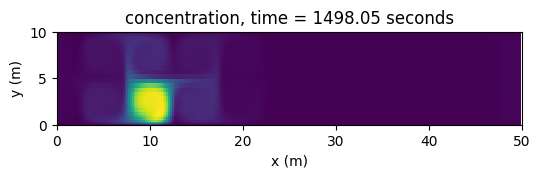

In [18]:
#U0=0.3 k=pi/5
# Set parameters
U0 = 0.3 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale
k=np.pi*0.2 #NEW gives 1 wavelengths in width 10 choose np.pi for 5 wavelengths (gave negative concentration)

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

#def u(x,y,k):
  #return U0*np.cos(k*x)*np.cos(k*y)
#def v(x,y,k):
  #return U0*np.sin(k*x)*np.sin(k*y)

# Fields CHANGED
c = dist.Field(name='c', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field CHANGED
u['g'] = U0*np.cos(k*x)*np.cos(k*y)
v['g'] = U0*np.sin(k*x)*np.sin(k*y)

# Substitutions CHANGED
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem CHANGED
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) + v*dy(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf()
    concentration = plt.pcolor(X, Y, c_save[n,:,:].T)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlim(0, L)
    plt.ylim(0, w)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('concentration, time = {0:.2f} seconds'.format(t_save[n]))
    return (concentration,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

In [19]:
concentration = False
for time in range(len(t_save)):
  for xpos in range(0,Nx):
    if c_save[time, xpos, -1] >0:
      print (f"pollution first crosses river at time = {t_save[time]} s, distance = {x[xpos,0]}m")
      concentration = True
      break
  if concentration == True:
    break

pollution first crosses river at time = 0.6510416666666667 s, distance = 0.0m


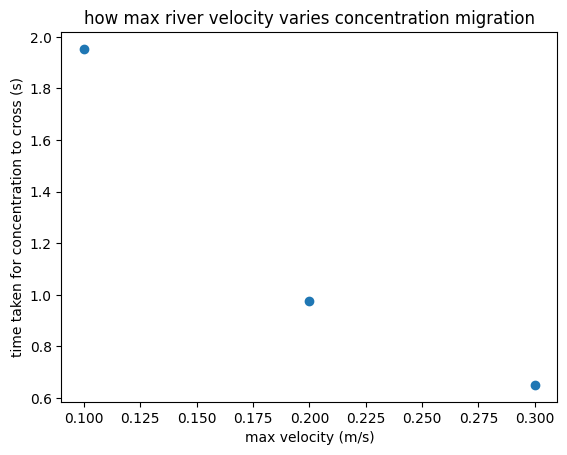

In [20]:
velocities = (0.1,0.2,0.3)
times = (1.953, 0.977, 0.651)

plt.figure()
plt.scatter(velocities, times)
plt.xlabel('max velocity (m/s)')
plt.ylabel('time taken for concentration to cross (s)')
plt.title('how max river velocity varies concentration migration')

plt.show()

This shows a negative correlation between river velocity and time to cross- showing that a faster river allows pollutant to spread across the river more effiently, possibly due to speeding up of eddies which were hypothesized to carry the pollutant and we have seen from previous parts that advection plays a more significant role than diffusion. I have not tested enough data points but this looks like the beginning of an exponential correlation.

In [21]:
#U0=0.1 k=2pi/5
# Set parameters
U0 = 0.1 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale
k=np.pi*0.4 #NEW

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors


# Fields CHANGED
c = dist.Field(name='c', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field CHANGED
u['g'] = U0*np.cos(k*x)*np.cos(k*y)
v['g'] = U0*np.sin(k*x)*np.sin(k*y)

# Substitutions CHANGED
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem CHANGED
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) + v*dy(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


2025-11-11 19:52:36,607 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s


INFO:__main__:Starting main loop


2025-11-11 19:52:36,612 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2025-11-11 19:52:36,708 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2025-11-11 19:52:36,761 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2025-11-11 19:52:36,814 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2025-11-11 19:52:36,868 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2025-11-11 19:52:36,922 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2025-11-11 19:52:36,975 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2025-11-11 19:52:37,031 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2025-11-11 19:52:37,089 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2025-11-11 19:52:37,143 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2025-11-11 19:52:37,211 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2025-11-11 19:52:37,265 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2025-11-11 19:52:37,319 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2025-11-11 19:52:37,374 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2025-11-11 19:52:37,427 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2025-11-11 19:52:37,482 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2025-11-11 19:52:37,538 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2025-11-11 19:52:37,592 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2025-11-11 19:52:37,646 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2025-11-11 19:52:37,700 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2025-11-11 19:52:37,758 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2025-11-11 19:52:37,813 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2025-11-11 19:52:37,866 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2025-11-11 19:52:37,920 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2025-11-11 19:52:37,969 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2025-11-11 19:52:38,020 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2025-11-11 19:52:38,071 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2025-11-11 19:52:38,124 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2025-11-11 19:52:38,175 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2025-11-11 19:52:38,238 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2025-11-11 19:52:38,296 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2025-11-11 19:52:38,349 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2025-11-11 19:52:38,403 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2025-11-11 19:52:38,456 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2025-11-11 19:52:38,507 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2025-11-11 19:52:38,557 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2025-11-11 19:52:38,610 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2025-11-11 19:52:38,661 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2025-11-11 19:52:38,715 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2025-11-11 19:52:38,772 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2025-11-11 19:52:38,831 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2025-11-11 19:52:38,887 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2025-11-11 19:52:38,937 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2025-11-11 19:52:38,996 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2025-11-11 19:52:39,050 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2025-11-11 19:52:39,108 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2025-11-11 19:52:39,163 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2025-11-11 19:52:39,218 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2025-11-11 19:52:39,285 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2025-11-11 19:52:39,338 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2025-11-11 19:52:39,393 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2025-11-11 19:52:39,448 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2025-11-11 19:52:39,509 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2025-11-11 19:52:39,660 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2025-11-11 19:52:39,748 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2025-11-11 19:52:39,828 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2025-11-11 19:52:39,914 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2025-11-11 19:52:39,999 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2025-11-11 19:52:40,080 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2025-11-11 19:52:40,166 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2025-11-11 19:52:40,254 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2025-11-11 19:52:40,359 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2025-11-11 19:52:40,520 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2025-11-11 19:52:40,582 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2025-11-11 19:52:40,636 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2025-11-11 19:52:40,694 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2025-11-11 19:52:40,748 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2025-11-11 19:52:40,803 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2025-11-11 19:52:40,860 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2025-11-11 19:52:40,921 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2025-11-11 19:52:41,025 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2025-11-11 19:52:41,116 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2025-11-11 19:52:41,203 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2025-11-11 19:52:41,283 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2025-11-11 19:52:41,397 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2025-11-11 19:52:41,549 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2025-11-11 19:52:41,651 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2025-11-11 19:52:41,734 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2025-11-11 19:52:41,806 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2025-11-11 19:52:41,812 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2025-11-11 19:52:41,816 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.6614 sec


2025-11-11 19:52:41,821 solvers 0/1 INFO :: Setup time (init - iter 0): 0.6614 sec


INFO:solvers:Warmup time (iter 0-10): 0.142 sec


2025-11-11 19:52:41,828 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.142 sec


INFO:solvers:Run time (iter 10-end): 5.056 sec


2025-11-11 19:52:41,833 solvers 0/1 INFO :: Run time (iter 10-end): 5.056 sec


INFO:solvers:CPU time (iter 10-end): 0.001404 cpu-hr


2025-11-11 19:52:41,837 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001404 cpu-hr


INFO:solvers:Speed: 2.6e+06 mode-stages/cpu-sec


2025-11-11 19:52:41,839 solvers 0/1 INFO :: Speed: 2.6e+06 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-11 19:52:42,177 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp5zlsgvir/temp.m4v


2025-11-11 19:52:42,179 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp5zlsgvir/temp.m4v


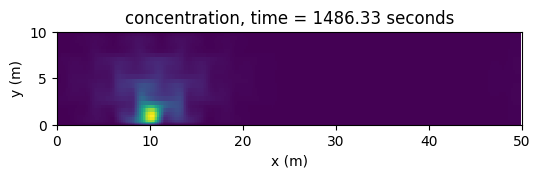

In [22]:
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf()
    concentration = plt.pcolor(X, Y, c_save[n,:,:].T)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlim(0, L)
    plt.ylim(0, w)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('concentration, time = {0:.2f} seconds'.format(t_save[n]))
    return (concentration,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

In [23]:
concentration = False
for time in range(len(t_save)):
  for xpos in range(0,Nx):
    if c_save[time, xpos, -1] >0:
      print (f"pollution first crosses river at time = {t_save[time]} s, distance = {x[xpos,0]}m")
      concentration = True
      break
  if concentration == True:
    break

pollution first crosses river at time = 1.953125 s, distance = 0.0m


## 3. Optional further investigations

* In the river pollution example, you might notice that the concentration field is mixed more effectively in the x-direction than in the y-direction. The combination of differential advection by the currents and cross-stream diffusion is very effective at mixing the plume in the x-direction. This is an example of Taylor dispersion (Taylor, 1953). Construct numerical experiments to quantify Taylor dispersion and its dependence on the current shear and the diffusivity. You could also separate the diffusivity into parts in the x and y directions with different coefficients.  If you set the x-component of the diffusivity to zero, then any spreading of the concentration in the x-direction should be due to Taylor dispersion.

* Try making the river speed a function of time. The easiest way to do this is to add a new equation so that Dedalus solves for the velocity in addition to the concentration field. For example, you could make the river speed decrease exponentially in time, or it could be sinusoidal in time.

* In the ocean mixing example, if $\kappa$ is a function of $x$ and $z$, what would this imply about the velocity field? You could even try writing a Dedalus script to solve the 2D advection/diffusion equation with a prescribed spatially-dependent $\kappa(x,z)$.


### References

Munk, W.H., 1966. Abyssal recipes. In Deep sea research and oceanographic abstracts (Vol. 13, No. 4, pp. 707-730). Elsevier.

Ferrari, R., Mashayek, A., McDougall, T.J., Nikurashin, M. and Campin, J.M., 2016. Turning ocean mixing upside down. Journal of Physical Oceanography, 46(7), pp.2239-2261.

Taylor, G.I., 1953. Dispersion of soluble matter in solvent flowing slowly through a tube. Proceedings of the Royal Society of London. Series A. Mathematical and Physical Sciences, 219(1137), pp.186-203.